**Todos**
*   Remove unnecessary imports of many nb_xxx classes
*   AppTabular should subclass AppBase
*   Move run_settings() and compare_settings() into app_lib 
*   Some cells cannot be run in order. Add comments there to make it clear how to run them, or put some flags. Ideally we should be able to execute the whole notebook sequentially.
*   Clean up all the other 'Old' cells and Debug Val Loss, and Home Credit Todo Later

### Import KD Libraries

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import IPython.core.debugger as db
from pathlib import Path
from functools import partial
import math
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [25]:
from nb_data import DisplayData, FeatureSet, FeatureList, TabularDataBundle
from nb_app import AppBase, AppTabular

In [6]:
from nb_util import save_pickle, load_pickle, accuracy, DebugRand
#from nb_data import DataBundle, CSVItemContainer, DfItemList, SentenceItemList, SentenceWordItemList, SentenceWordIdItemList, SortishSampler, SortSampler
#from nb_training import Trainer, Callback, CudaCB, ProgressCallback, MetricsGrp, LossMetricsCB, AverageMetricsCB, DebugTracker, DebugYhatLossCB
from nb_training import Trainer, Callback, CudaCB, ProgressCallback, AverageMetricsCB
from nb_optimiser import HyperParams, Recorder
from nb_arch import ArchBase

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from nb_util import accuracy, accuracy_thresh, mse, rmspe, save_pickle, load_pickle, DebugRand
from nb_training import Trainer, CancelFitException, Callback, MetricsGrp, LossMetricsCB, AverageMetricsCB, RocAucMetricsCB, AbortTrainCB, ProgressCallback, CudaCB, DebugTracker, DebugYhatLossCB
#from nb_optimiser import get_optimiser, Recorder, adam_opt_func, HyperParams
from nb_optimiser import get_optimiser, Recorder, adam_opt_func, HyperParams, LRRangeFind
#from nb_hooks import Hooks, Hook
from nb_hooks import Hooks, DebugActivationHook
from nb_util import test_near_zero

### Home Credit

In [8]:
# https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda
# https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
# https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
# https://www.kaggle.com/ogrellier/lighgbm-with-selected-features
# https://www.kaggle.com/c/home-credit-default-risk/discussion/57750
# https://www.kaggle.com/ogrellier/feature-selection-with-null-importances
# https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm
# https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
#
#
# https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm
# https://www.kaggle.com/mmueller/stacking-starter

In [26]:
class TabularHomeCreditDataBundle(TabularDataBundle):
  def __init__(self, csv_path, test_csv_path, related_csv_paths, **kwargs):
    super().__init__(csv_path, test_csv_path, related_csv_paths, prepare_fn=self.prepare, test_data=True, **kwargs)

  # ----------------------------
  # Define data files
  # ----------------------------
  @staticmethod
  def get_data_files():
    data_files = {}
    data_files['main'] = 'application_train.csv'
    data_files['test'] = 'application_test.csv'
    data_files['related'] = ['bureau.csv', 'bureau_balance.csv', 'previous_application.csv', 'credit_card_balance.csv', 'POS_CASH_balance.csv', 'installments_payments.csv']

    return data_files

  # ----------------------------
  # Define related dfs for creating subsets
  # ----------------------------
  @classmethod
  def subset_related(cls):
    idx_related = {'bureau': 'bu', 'bureau_balance': 'bb', 'previous_application': 'pa', 'credit_card_balance': 'cc', 'POS_CASH_balance': 'pc', 'installments_payments': 'ip'}
    merge_fn = cls._merge_all
    return (idx_related, merge_fn)

  # ----------------------------
  # Calculate relative percentage amounts for  
  # ----------------------------   
  def _prepare_pct_amounts(self, il):
    il.df['PCT_CREDIT'] = il.df['AMT_CREDIT'] / il.df['AMT_INCOME_TOTAL']
    il.df['PCT_ANNUITY'] = il.df['AMT_ANNUITY'] / il.df['AMT_INCOME_TOTAL']
    il.df['PCT_GOODS_PRICE'] = il.df['AMT_GOODS_PRICE'] / il.df['AMT_INCOME_TOTAL']
    il.df['PCT_PAYMENT'] = il.df['AMT_ANNUITY'] / il.df['AMT_CREDIT']

    il.df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    il.df['PCT_DAYS_EMPLOYED'] = il.df['DAYS_EMPLOYED'] / il.df['DAYS_BIRTH']

    pct_cont_cols = ['PCT_CREDIT', 'PCT_ANNUITY', 'PCT_GOODS_PRICE', 'PCT_PAYMENT', 'PCT_DAYS_EMPLOYED']

    fs = FeatureSet('pct', [], pct_cont_cols)
    return (fs)

  # ----------------------------
  # Add bins to partition continuous columns based on numerical ranges 
  # ----------------------------   
  def _prepare_bin(self, il):
    il.bin_num (col='DAYS_EMPLOYED', bin_col='BIN_DAYS_EMPLOYED', bins=[-10000, -5000, -3000, -1000, 0, 1000000], labels=[5, 4, 3, 2, 1])
    bin_cat_cols = ['BIN_DAYS_EMPLOYED']

    fs = FeatureSet('bin', bin_cat_cols, [])
    return (fs)

  # ----------------------------
  # Rolled up aggregates from 'bureau'
  # ----------------------------   
  def _prepare_bureau_rollup(self, il):
    bureau_agg_cat=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
    bureau_agg_cont = {
        # Days before current application did client apply for credit
        'DAYS_CREDIT': ['mean', 'min', 'max', 'count'],
        # Remaining duration of CB credit at time of current application
        'DAYS_CREDIT_ENDDATE': ['mean', 'min', 'max', 'sum'],
        # Current credit amount
        'AMT_CREDIT_SUM': ['mean', 'min', 'max', 'sum'],
        # How many days before current application did last information come
        'DAYS_CREDIT_UPDATE': ['mean', 'max'],
        }

    remap_cat_dict = {
        'Active': 'Active',
        'Closed': 'Closed',
        'Sold': 'Closed',
    }
    il.remap_val(df_name='bureau', col='CREDIT_ACTIVE', remap_dict=remap_cat_dict)

    il.rollup(df_name='bureau', index=['SK_ID_CURR'], group_cols=['CREDIT_ACTIVE'],
          cat_cols=bureau_agg_cat, agg_cont=bureau_agg_cont)
    il.bureau_df = il.bureau_df.add_prefix('BU_')
    bureau_cont_cols = il.bureau_df.columns.tolist()

    il.bureau_df = il.bureau_df.reset_index()
    il.join_df(right_df_name='bureau', left_on='SK_ID_CURR')
    return bureau_cont_cols

  # ----------------------------
  # Rolled up aggregates from 'bureau balance'
  # ----------------------------   
  def _prepare_bureau_balance_rollup(self, il):
    bureau_balance_agg_cat=['STATUS']
    bureau_balance_agg_cont = {
        # Month of balance relative to application date
        'MONTHS_BALANCE': ['min', 'max'],
        }

    # Merge Status category values which are similar in meaning
    remap_cat_dict = {
      '0': 'paid',
      '1': 'overdue',
      '2': 'overdue',
      '3': 'overdue',
      'C': 'complete',
      'X': 'X',
    }
    il.remap_val(df_name='bureau_balance', col='STATUS', remap_dict=remap_cat_dict)

    # First rollup to the Bureau ID level
    il.rollup(df_name='bureau_balance', index=['SK_ID_BUREAU'], group_cols=['STATUS'],
       cat_cols=bureau_balance_agg_cat, agg_cont=bureau_balance_agg_cont, 
    )

    # Then rollup to the Curr ID level. Since Bureau Balance doesn't have a Curr ID column,
    # we first pull that column in by joining with the Bureau df. Note that the left df
    # for this join is Bureau Balance.
    il.join_df(df_name='bureau_balance', right_df_name='bureau', left_on='SK_ID_BUREAU', how='inner')
    curr_agg_cont = {
       'STATUS_X': ['mean'], 'STATUS_complete': ['mean'], 'STATUS_overdue': ['mean','sum'], 'STATUS_paid': ['mean', 'sum'],
       'MONTHS_BALANCE_max_X': ['max'], 'MONTHS_BALANCE_max_complete': ['max'], 'MONTHS_BALANCE_max_overdue': ['max'], 'MONTHS_BALANCE_max_paid': ['max'],
       'MONTHS_BALANCE_min_X': ['min'], 'MONTHS_BALANCE_min_complete': ['min'], 'MONTHS_BALANCE_min_overdue': ['min'], 'MONTHS_BALANCE_min_paid': ['min']
    }
    il.rollup(df_name='bureau_balance', index=['SK_ID_CURR'], group_cols=None,
       cat_cols=None, agg_cont=curr_agg_cont, 
    )
    il.bureau_balance_df = il.bureau_balance_df.add_prefix('BB_')
    bureau_balance_cont_cols = il.bureau_balance_df.columns.tolist()

    # Finally merge with the main df
    il.bureau_balance_df = il.bureau_balance_df.reset_index()
    il.join_df(right_df_name='bureau_balance', left_on='SK_ID_CURR')

    return bureau_balance_cont_cols

  # ----------------------------
  # Rolled up aggregates from 'previous application'
  # ----------------------------   
  def _prepare_pa_rollup(self, il):
    pa_agg_cat = ['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON',	
                  'NAME_CLIENT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE']
    pa_agg_cont = {
        # Annuity of previous application
        'AMT_ANNUITY': ['mean', 'min', 'max', 'sum'],
        # Credit asked for in previous application
        'AMT_APPLICATION': ['mean', 'min', 'max', 'sum'],
        # Final credit amount in previous application
        'AMT_CREDIT': ['mean', 'min', 'max', 'sum'],
        # Price of good that client asked for
        'AMT_GOODS_PRICE': ['mean', 'min', 'max', 'sum'],
        'PCT_CREDIT': ['min', 'max', 'mean'],
        'PCT_ANNUITY': ['min', 'max', 'mean'],
        'PCT_GOODS_PRICE': ['min', 'max', 'mean'],
        # Number of payment installments
        'CNT_PAYMENT': 'mean',
        # Number of days before current application, when previous application was decided
        'DAYS_DECISION': ['min', 'max']
        }

    il.previous_application_df['PCT_CREDIT'] = il.previous_application_df['AMT_CREDIT'] / il.previous_application_df['AMT_APPLICATION']
    il.previous_application_df['PCT_ANNUITY'] = il.previous_application_df['AMT_ANNUITY'] / il.previous_application_df['AMT_APPLICATION']
    il.previous_application_df['PCT_GOODS_PRICE'] = il.previous_application_df['AMT_GOODS_PRICE'] / il.previous_application_df['AMT_APPLICATION']

    il.rollup(df_name='previous_application', index=['SK_ID_CURR'], group_cols=['NAME_CONTRACT_STATUS'],
              cat_cols=pa_agg_cat, agg_cont=pa_agg_cont)
    il.previous_application_df = il.previous_application_df.add_prefix('PA_')
    pa_cont_cols = il.previous_application_df.columns.tolist()

    il.previous_application_df = il.previous_application_df.reset_index()
    il.join_df(right_df_name='previous_application', left_on='SK_ID_CURR')

    return pa_cont_cols

  # ----------------------------
  # Rolled up aggregates from 'credit card balance'
  # ----------------------------   
  def _prepare_cc_balance_rollup(self, il):
    cc_balance_agg_cat = ['NAME_CONTRACT_STATUS']
    cc_balance_agg_cont = {
        # Month of balance relative to application date
        'MONTHS_BALANCE': ['min', 'max'],
        'AMT_CREDIT_LIMIT_ACTUAL' : ['mean'],
        'AMT_PAYMENT_CURRENT': ['mean'],
        }

    # First rollup to the Prev ID level
    il.rollup(df_name='credit_card_balance', index=['SK_ID_CURR', 'SK_ID_PREV'], group_cols=['NAME_CONTRACT_STATUS'],
       cat_cols=cc_balance_agg_cat, agg_cont=cc_balance_agg_cont)

    # Then rollup to the Curr ID level
    curr_agg_cont = {
        'NAME_CONTRACT_STATUS_Active': ['mean'], 'NAME_CONTRACT_STATUS_Completed': ['mean'], 'NAME_CONTRACT_STATUS_Signed': ['mean'], 
        'AMT_CREDIT_LIMIT_ACTUAL_mean_Active': ['mean'], 'AMT_CREDIT_LIMIT_ACTUAL_mean_Completed': ['mean'], 'AMT_CREDIT_LIMIT_ACTUAL_mean_Signed': ['mean'],
        'AMT_PAYMENT_CURRENT_mean_Active': ['mean'],
        # This combination does not occur as there are no Payments for Completed and Signed status 
        # 'AMT_PAYMENT_CURRENT_mean_Completed': ['mean'], 'AMT_PAYMENT_CURRENT_mean_Signed': ['mean'], 
        'MONTHS_BALANCE_max_Active': ['max'], 'MONTHS_BALANCE_max_Completed': ['max'], 'MONTHS_BALANCE_max_Signed': ['max'],
        'MONTHS_BALANCE_min_Active': ['min'], 'MONTHS_BALANCE_min_Completed': ['min'], 'MONTHS_BALANCE_min_Signed': ['min']
    }
    il.rollup(df_name='credit_card_balance', index=['SK_ID_CURR'], group_cols=None,
       cat_cols=None, agg_cont=curr_agg_cont, 
    )
    il.credit_card_balance_df = il.credit_card_balance_df.add_prefix('CC_')
    cc_balance_cont_cols = il.credit_card_balance_df.columns.tolist()

    # Finally merge with the main df
    il.credit_card_balance_df = il.credit_card_balance_df.reset_index()
    il.join_df(right_df_name='credit_card_balance', left_on='SK_ID_CURR')

    return cc_balance_cont_cols

  # ----------------------------
  # Rolled up aggregates from 'POS cash balance'
  # ----------------------------   
  def _prepare_pos_balance_rollup(self, il):
    pos_balance_agg_cat = ['NAME_CONTRACT_STATUS']
    pos_balance_agg_cont = {
        # Number of installments
        'CNT_INSTALMENT': 'mean',
        # Number of installments left
        'CNT_INSTALMENT_FUTURE': 'min',
        # Month of balance relative to application date
        'MONTHS_BALANCE': ['min', 'max']
        }

    remap_cat_dict = {
      'Active': 'paid',
      'Completed': 'complete',
      'Returned to the store': 'approved',
      'Signed': 'approved',
    }
    il.remap_val(df_name='POS_CASH_balance', col='NAME_CONTRACT_STATUS', remap_dict=remap_cat_dict)

    # First rollup to the Prev ID level
    il.rollup(df_name='POS_CASH_balance', index=['SK_ID_CURR', 'SK_ID_PREV'], group_cols=['NAME_CONTRACT_STATUS'],
                    cat_cols=pos_balance_agg_cat, agg_cont=pos_balance_agg_cont)

    # Then rollup to the Curr ID level
    curr_agg_cont = {
        'NAME_CONTRACT_STATUS_approved': ['mean'], 'NAME_CONTRACT_STATUS_complete': ['mean'], 'NAME_CONTRACT_STATUS_paid': ['mean'], 
        'CNT_INSTALMENT_mean_approved': ['mean'], 'CNT_INSTALMENT_mean_complete': ['mean'], 'CNT_INSTALMENT_mean_paid': ['mean'],
        'CNT_INSTALMENT_FUTURE_min_approved': ['min'], 'CNT_INSTALMENT_FUTURE_min_complete': ['min'], 'CNT_INSTALMENT_FUTURE_min_paid': ['min'],
        'MONTHS_BALANCE_max_approved': ['max'], 'MONTHS_BALANCE_max_complete': ['max'], 'MONTHS_BALANCE_max_paid': ['max'], 
        'MONTHS_BALANCE_min_approved': ['min'], 'MONTHS_BALANCE_min_complete': ['min'], 'MONTHS_BALANCE_min_paid': ['min']
    }
    il.rollup(df_name='POS_CASH_balance', index=['SK_ID_CURR'], group_cols=None,
       cat_cols=None, agg_cont=curr_agg_cont, 
    )
    il.POS_CASH_balance_df = il.POS_CASH_balance_df.add_prefix('PB_')
    pos_balance_cont_cols = il.POS_CASH_balance_df.columns.tolist()

    # Finally merge with the main df
    il.POS_CASH_balance_df = il.POS_CASH_balance_df.reset_index()
    il.join_df(right_df_name='POS_CASH_balance', left_on='SK_ID_CURR')

    return pos_balance_cont_cols

  # ----------------------------
  # Rolled up aggregates from 'installments payments'
  # ----------------------------   
  def _prepare_installments_payments_rollup(self, il):
    installments_payments_agg_cont = {
        'OVERDUE': ['mean', 'sum'],
        'AMT_OVERDUE': 'sum',
        'PCT_AMT_OVERDUE': 'mean',
        'AMT_PAYMENT': 'mean',
        'DAYS_ENTRY_PAYMENT': ['min', 'max']}

    il.installments_payments_df['OVERDUE'] = il.installments_payments_df['DAYS_ENTRY_PAYMENT'] - il.installments_payments_df['DAYS_INSTALMENT'] > 0
    il.installments_payments_df['AMT_OVERDUE'] = il.installments_payments_df['AMT_INSTALMENT'] - il.installments_payments_df['AMT_PAYMENT']
    il.installments_payments_df['PCT_AMT_OVERDUE'] = il.installments_payments_df['AMT_OVERDUE'] / il.installments_payments_df['AMT_INSTALMENT']

    # First rollup to the Prev ID level
    il.rollup(df_name='installments_payments', index=['SK_ID_CURR', 'SK_ID_PREV'], group_cols=None,
       cat_cols=None, agg_cont=installments_payments_agg_cont )

    # Then rollup to the Curr ID level
    curr_agg_cont = {
        'AMT_OVERDUE_sum': ['sum'], 'PCT_AMT_OVERDUE_mean': ['mean'], 'AMT_PAYMENT_mean': ['mean'], 
        'DAYS_ENTRY_PAYMENT_max': ['max'], 'DAYS_ENTRY_PAYMENT_min': ['min'], 
        'OVERDUE_mean': ['mean'], 'OVERDUE_sum': ['sum']
    }
    il.rollup(df_name='installments_payments', index=['SK_ID_CURR'], group_cols=None,
       cat_cols=None, agg_cont=curr_agg_cont, 
    )
    il.installments_payments_df = il.installments_payments_df.add_prefix('IP_')
    installments_payments_cont_cols = il.installments_payments_df.columns.tolist()

    # Finally merge with the main df
    il.installments_payments_df = il.installments_payments_df.reset_index()
    il.join_df(right_df_name='installments_payments', left_on='SK_ID_CURR')

    return installments_payments_cont_cols

  # ----------------------------
  # Rolled up aggregates of all related tables
  # ----------------------------   
  def _prepare_rollup(self, il):
    bureau_balance_cont_cols = self._prepare_bureau_balance_rollup(il)
    bureau_cont_cols = self._prepare_bureau_rollup(il)

    cc_balance_cont_cols = self._prepare_cc_balance_rollup(il)
    pos_balance_cont_cols = self._prepare_pos_balance_rollup(il)
    installments_payments_cont_cols = self._prepare_installments_payments_rollup(il)

    pa_cont_cols = self._prepare_pa_rollup(il)
    rollup_cont_cols = (bureau_balance_cont_cols + bureau_cont_cols + 
                        cc_balance_cont_cols + pos_balance_cont_cols + installments_payments_cont_cols +
                        pa_cont_cols)
    fs = FeatureSet('rollup', [], rollup_cont_cols)
    return (fs)

  # ----------------------------
  # Basic training columns
  # ----------------------------   
  def _prepare_base(self, il):
    base_cont_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR']
    base_cat_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE']

    fs = FeatureSet('base', base_cat_cols, base_cont_cols)
    return (fs)

  # ----------------------------
  # Prepare and pre-process the data
  # ----------------------------   
  def prepare(self, il, is_test=False):
    cols_tgt = ['TARGET']

    # Since the test data has no Target columns, add Target columns with dummy
    # data so that the same 'y' Extract and Convert logic that is used for the
    # training and validation data can be used for the test data
    if (is_test):
      for col in cols_tgt:
        il.df[col] = 0

    fl = FeatureList()
    fs = self._prepare_base(il)
    fl.add_fs(fs)

    fs = self._prepare_pct_amounts(il)
    fl.add_fs(fs)

    fs = self._prepare_bin(il)
    fl.add_fs(fs)

    fs = self._prepare_rollup(il)
    fl.add_fs(fs)

    il = super().prepare(il, fl, cols_tgt)
    return il

  # ----------------------------
  # ----------------------------
  def prepare_kaggle(self, il, is_test=False):
    cols_tgt = ['TARGET']

    if (is_test):
      for col in cols_tgt:
        il.df[col] = 0

    fl = FeatureList()
    il.df = fook_df
    fooc = fook_df.isna().sum()
    ec = fooc[fooc.values == len(fook_df)].index.tolist()
    il.remove_col(cols=ec)

    kaggle_cat_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
                       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
                       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

    kaggle_cont_cols=il.df.columns.tolist()
    kaggle_cont_cols.remove('TARGET')
    kaggle_cont_cols.remove('SK_ID_CURR')
    for col in kaggle_cat_cols:
      kaggle_cont_cols.remove(col)

    fs = FeatureSet('kaggle', kaggle_cat_cols, kaggle_cont_cols)
    fl.add_fs(fs)

    il = super().prepare(il, fl, cols_tgt)
    return il

**Set Data Paths**

In [10]:
# Initially start with only the main data files without related files, create
# subsets and complete end-to-end models. Then incrementally add related files
# one at a time, build up the merge and prepare functions, and use them to
# create subsets.
app_dir='homecredit'
subset_sz=6400
#subset_sz='full'
homecredit_data_files = TabularHomeCreditDataBundle.get_data_files()
root_path, download_path, data_path, debug_path, hist_path, main_file_path, test_file_path, related_csv_paths = AppTabular.set_data_path (app_dir, gd_path, subset_sz, homecredit_data_files)
root_path, download_path, data_path, debug_path, hist_path, main_file_path, test_file_path, related_csv_paths
pickle_dir = root_path/'pickle'

(PosixPath('/content'),
 PosixPath('/content/homecredit'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/debug'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/hist'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/application_train.csv'),
 PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/application_test.csv'),
 [PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/bureau.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/bureau_balance.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/previous_application.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/credit_card_balance.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/POS_CASH_balance.csv'),
  PosixPath('gdrive/My Drive/Colab Data/fastai-v3/da

**Kaggle Download**

In [ ]:
def kaggle_data(data_type, data_name):
  # Run this cell and select the kaggle.json file downloaded
  # from the Kaggle account settings page.
  from google.colab import files
  files.upload()

  # Let's make sure the kaggle.json file is present.
  !ls -lha kaggle.json

  # Next, install the Kaggle API client after forcing an upgrade
  !pip uninstall -y kaggle
  !pip install --upgrade pip
  !pip install kaggle==1.5.6
  !kaggle -v

  # Reason for doing a force-upgrade. The underlying problem: Colab installs both py2 and py3 
  # packages, and (for historical reasons) the py2 packages are installed second. kaggle is a 
  # wrapper installed by the kaggle python package; since we do py2 second, the py2 wrapper 
  # is in /usr/local/bin, and happens to be an older version.

  # The Kaggle API client expects this file to be in ~/.kaggle,
  # so move it there.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 ~/.kaggle/kaggle.json

  # List available datasets.
  !kaggle {data_type} list

  # First, you have to login to Kaggle, go to that competition's page, navigate to 
  # the Rules tab and accept the terms and conditions. Unless you do that, you will get
  # a 403-Forbidden error when you run the command below

  # Copy the carvana data set locally.
  !kaggle {data_type} download {data_name}

In [ ]:
# Upload the 'kaggle.json' file from local disk
kaggle_data_type = 'competitions'
kaggle_data_name = 'home-credit-default-risk'
kaggle_data(kaggle_data_type, kaggle_data_name)

In [ ]:
def credit_extract(zip_file, out_path):
  !zipinfo {zip_file}

  !unzip {zip_file} -d {out_path} >> /dev/null
  !ls -l {out_path}

credit_extract(f'{kaggle_data_name}.zip', data_path)

**Make Subset - don't use**

In [ ]:
# !!!!!!!!! This doesn't work right right now, use the alternate Make Subset cell below.
# make_subset() does not currently support the Home Credit use case. See the comments in that
# function for details.

# When you start development, TabularHomeCreditDataBundle will not override the subset_related 
# method, so subsets will be created only for the main files. Later as you incrementally add 
# related files, you can define that method and add files into it one by one

create_subset_sz=0
# create_subset_sz=100
if (create_subset_sz > 0):
  # Read full source data
  assert(subset_sz == 'full')
  rtdb = TabularDataBundle(main_file_path, test_file_path, related_csv_paths=related_csv_paths)

  # Create subset data of the given size
  idx_related, merge_fn = TabularHomeCreditDataBundle.subset_related()
  subset_data_path = AppTabular.subset_path(app_dir, gd_path, create_subset_sz)
  rtdb.make_subset(idx_related, merge_fn, subset_data_path, subset_sz=create_subset_sz)

**Make Subset - use this**

In [ ]:
subset_main_df = pd.read_csv(full_main_file_path).iloc[:6400]
subset_main_df.to_csv(subset_main_file_path, index=False)

subset_test_df = pd.read_csv(full_test_file_path).iloc[:640]
subset_test_df.to_csv(subset_test_file_path, index=False)                                           

combine_df = subset_main_df.append(subset_test_df)

subset_bureau_df = pd.read_csv(full_bureau_path)
curr_key = 'SK_ID_CURR'
subset_bureau_df = combine_df[[curr_key, 'CODE_GENDER']].merge(subset_bureau_df, how='inner', left_on=curr_key, right_on=curr_key, suffixes=('_l', '_r')).drop(columns=['CODE_GENDER'])
subset_bureau_df.to_csv(subset_bureau_path, index=False)

subset_bureau_balance_df = pd.read_csv(full_bureau_balance_path)
bureau_key='SK_ID_BUREAU'
subset_bureau_balance_df = subset_bureau_df[[bureau_key, 'DAYS_CREDIT']].merge(subset_bureau_balance_df, how='inner', left_on=bureau_key, right_on=bureau_key, suffixes=('_l', '_r')).drop(columns=['DAYS_CREDIT'])
subset_bureau_balance_df.to_csv(subset_bureau_balance_path, index=False)

subset_pa_df = pd.read_csv(full_pa_path)
subset_pa_df = combine_df[[curr_key, 'CODE_GENDER']].merge(subset_pa_df, how='inner', left_on=curr_key, right_on=curr_key, suffixes=('_l', '_r')).drop(columns=['CODE_GENDER'])
subset_pa_df.to_csv(subset_pa_path, index=False)

curr_prev_key=['SK_ID_CURR', 'SK_ID_PREV']

subset_cc_balance_df = pd.read_csv(full_cc_balance_path)
subset_cc_balance_df = subset_pa_df[curr_prev_key].merge(subset_cc_balance_df, how='inner', left_on=curr_prev_key, right_on=curr_prev_key, suffixes=('_l', '_r'))
subset_cc_balance_df.to_csv(subset_cc_balance_path, index=False)

subset_pos_balance_df = pd.read_csv(full_pos_balance_path)
subset_pos_balance_df = subset_pa_df[curr_prev_key].merge(subset_pos_balance_df, how='inner', left_on=curr_prev_key, right_on=curr_prev_key, suffixes=('_l', '_r'))
subset_pos_balance_df.to_csv(subset_pos_balance_path, index=False)

subset_installment_df = pd.read_csv(full_installment_path)
subset_installment_df = subset_pa_df[curr_prev_key].merge(subset_installment_df, how='inner', left_on=curr_prev_key, right_on=curr_prev_key, suffixes=('_l', '_r'))
subset_installment_df.to_csv(subset_installment_path, index=False)

**Exploratory Data Analysis**

In [ ]:
hcdb = TabularDataBundle(main_file_path, related_csv_paths=related_csv_paths)
train_il = hcdb.process(steps=['load'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--------- Tabular Home Credit DataBundle init gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/application_train.csv None [PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/bureau.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/bureau_balance.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/previous_application.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/credit_card_balance.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/POS_CASH_balance.csv'), PosixPath('gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/installments_payments.csv')]
gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/bureau.csv memory reduced by 47.8% from 4.34 MB to 2.27 MB
gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/bureau_balance.csv memory reduced by 45.8% from 10.07 MB to 5.45 MB
gdrive/My Drive/Colab Data/fastai-v3/data/homecredit_6400/previous_

In [ ]:
train_il.df.sample()
train_il.bureau_df.sample()
train_il.bureau_balance_df.sample()
train_il.previous_application_df.sample()
train_il.credit_card_balance_df.sample()
train_il.POS_CASH_balance_df.sample()
train_il.installments_payments_df.sample()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6102,107135,0,Cash loans,F,N,Y,1,247500.0,1048806.0,73125.0,990000.0,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,0.00963,-15568,-4135,-9666.0,-4358,NaN,1,1,1,1,1,0,Sales staff,3.0,2,2,TUESDAY,11,0,0,0,0,0,0,...,NaN,0.1441,NaN,0.0022,NaN,block of flats,0.1119,Panel,No,1.0,0.0,1.0,0.0,-1769.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
12567,103169,5375815,Closed,currency 1,-2888,0,-2585.0,-2585.0,0.0,0,49495.5,0.0,0.0,0.0,Consumer credit,-2583,NaN


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
177789,6108101,-38,X


,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
25725,106520,2721382,Consumer loans,13136.535156,120730.5,118219.5,12073.5,120730.5,MONDAY,11,Y,1,0.10092,NaN,NaN,XAP,Approved,-996,Cash through the bank,XAP,Family,Refreshed,Construction Materials,POS,XNA,Stone,30,Construction,10.0,low_normal,POS industry with interest,365243.0,-965.0,-695.0,-695.0,-689.0,0.0


,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
48072,101225,1984467,-1,86174.148438,94500,0.0,0.0,0.0,0.0,4811.084961,4950.0,205.830002,84983.3125,86174.148438,86174.148438,0.0,0,0.0,0.0,10.0,Active,0,0


,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
97981,104245,1100787,-12,7.0,0.0,Completed,0,0


,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
92628,103177,2418373,1.0,1,-1427.0,-1429.0,13477.049805,13477.049805


In [ ]:
mds = hcdb.display_metadata(train_il)

features_dict = {
  'key'     : ['SK_ID_CURR'],
  'primary' : ['TARGET', 'AMT_CREDIT', 'AMT_INCOME_TOTAL'],
  'target' : ['TARGET'],
}
train_il.add_features_dict(features_dict, df_name=None, mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
SK_ID_CURR,int32,6400,0,0.00,100351,0.00,continuous,NaN,100002.00,103739.97,103736.50,107466.00
TARGET,int8,6400,0,0.00,0,92.20,secondary,NaN,0.00,0.08,0.00,1.00
NAME_CONTRACT_TYPE,object,6400,0,0.00,Cash loans,90.00,categorical,2,NaN,NaN,NaN,NaN
CODE_GENDER,object,6400,0,0.00,F,66.20,categorical,2,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,object,6400,0,0.00,N,66.20,categorical,2,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,object,6400,0,0.00,Y,69.90,categorical,2,NaN,NaN,NaN,NaN
CNT_CHILDREN,int8,6400,0,0.00,0,70.30,secondary,NaN,0.00,0.41,0.00,7.00
AMT_INCOME_TOTAL,float32,6400,0,0.00,135000.00,11.10,continuous,NaN,25650.00,167474.05,144000.00,1935000.00
AMT_CREDIT,float32,6400,0,0.00,450000.00,3.10,continuous,NaN,45000.00,596182.50,508495.50,2517300.00
AMT_ANNUITY,float32,6400,0,0.00,9000.00,2.40,continuous,NaN,2596.50,26989.19,24889.50,135936.00


In [ ]:
mds = hcdb.display_metadata(train_il, 'credit_card_balance')

features_dict = {
  'key'     : ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'],
  'primary' : ['AMT_CREDIT_LIMIT_ACTUAL'],
}
train_il.add_features_dict(features_dict, df_name='credit_card_balance', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
SK_ID_CURR,int32,51489,0,0.00,105479,0.20,continuous,NaN,100006.00,103578.70,103518.00,107465.00
SK_ID_PREV,int32,51489,0,0.00,1731051,0.20,continuous,NaN,1000661.00,1886402.22,1895351.00,2843337.00
MONTHS_BALANCE,int8,51489,0,0.00,-4,3.40,continuous,NaN,-96.00,-28.25,-21.00,-1.00
AMT_BALANCE,float32,51489,0,0.00,0.00,54.90,secondary,NaN,-48170.25,66751.42,0.00,951093.62
AMT_CREDIT_LIMIT_ACTUAL,int32,51489,0,0.00,0,14.80,continuous,NaN,0.00,181050.17,135000.00,900000.00
AMT_DRAWINGS_ATM_CURRENT,float32,51489,12871,25.00,0.00,62.90,secondary,NaN,0.00,7874.88,0.00,900000.00
AMT_DRAWINGS_CURRENT,float32,51489,0,0.00,0.00,82.00,secondary,NaN,0.00,9272.36,0.00,1381595.00
AMT_DRAWINGS_OTHER_CURRENT,float32,51489,12871,25.00,0.00,74.70,secondary,NaN,0.00,378.68,0.00,718848.00
AMT_DRAWINGS_POS_CURRENT,float32,51489,12871,25.00,0.00,66.60,secondary,NaN,0.00,4091.12,0.00,1381595.00
AMT_INST_MIN_REGULARITY,float32,51489,4277,8.31,0.00,49.50,continuous,NaN,0.00,3885.91,0.00,47344.82


In [ ]:
mds = hcdb.display_metadata(train_il, 'previous_application')

features_dict = {
  'key'     : ['SK_ID_CURR', 'SK_ID_PREV'],
  'primary' : ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT'],
}
# Include NFLAG_LAST_APPL_IN_DAY
# Categorical - HOUR_APPR_PROCESS_START
train_il.add_features_dict(features_dict, df_name='previous_application', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
SK_ID_CURR,int32,32990,0,0.00,104630,0.20,continuous,NaN,100001.00,103547.57,103448.50,107466.00
SK_ID_PREV,int32,32990,0,0.00,2754644,0.00,continuous,NaN,1000002.00,1921344.00,1921998.00,2845378.00
NAME_CONTRACT_TYPE,object,32990,0,0.00,Cash loans,45.40,categorical,4,NaN,NaN,NaN,NaN
AMT_ANNUITY,float32,32990,7576,22.96,2250.00,1.80,continuous,NaN,0.00,15929.67,11250.00,215427.06
AMT_APPLICATION,float32,32990,0,0.00,0.00,23.80,continuous,NaN,0.00,174800.08,70155.00,3150000.00
AMT_CREDIT,float32,32990,0,0.00,0.00,20.50,continuous,NaN,0.00,196057.94,80079.75,3749053.50
AMT_DOWN_PAYMENT,float32,32990,17845,54.09,0.00,22.30,secondary,NaN,0.00,6227.82,45.00,630000.00
AMT_GOODS_PRICE,float32,32990,7713,23.38,45000.00,2.70,continuous,NaN,0.00,228138.41,111955.50,3150000.00
WEEKDAY_APPR_PROCESS_START,object,32990,0,0.00,TUESDAY,15.60,categorical,7,NaN,NaN,NaN,NaN
HOUR_APPR_PROCESS_START,int8,32990,0,0.00,11,11.60,continuous,NaN,0.00,12.53,12.00,23.00


In [ ]:
mds = hcdb.display_metadata(train_il, 'bureau')

features_dict = {
  'key'     : ['SK_ID_CURR', 'SK_ID_BUREAU'],
  'primary' : ['CREDIT_ACTIVE', 'AMT_CREDIT_SUM', 'DAYS_CREDIT_ENDDATE'],
}
# Include AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE
train_il.add_features_dict(features_dict, df_name='bureau', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
SK_ID_CURR,int32,33480,0,0.00,101140,0.10,continuous,NaN,100001.00,103616.39,103519.00,107466.00
SK_ID_BUREAU,int32,33480,0,0.00,6621183,0.00,continuous,NaN,5000013.00,5911022.95,5895460.50,6843443.00
CREDIT_ACTIVE,object,33480,0,0.00,Closed,62.70,categorical,3,NaN,NaN,NaN,NaN
CREDIT_CURRENCY,object,33480,0,0.00,currency 1,99.90,categorical,3,NaN,NaN,NaN,NaN
DAYS_CREDIT,int16,33480,0,0.00,-546,0.10,continuous,NaN,-2922.00,-1145.48,-989.00,-1.00
CREDIT_DAY_OVERDUE,int16,33480,0,0.00,0,99.80,secondary,NaN,0.00,0.88,0.00,2571.00
DAYS_CREDIT_ENDDATE,float32,33480,1939,5.79,4.00,0.10,continuous,NaN,-41819.00,533.57,-334.00,31198.00
DAYS_ENDDATE_FACT,float32,33480,12409,37.06,-301.00,0.10,secondary,NaN,-42023.00,-1028.27,-911.00,-1.00
AMT_CREDIT_MAX_OVERDUE,float32,33480,21806,65.13,0.00,27.70,secondary,NaN,0.00,3389.34,0.00,4206343.50
CNT_CREDIT_PROLONG,int8,33480,0,0.00,0,99.40,secondary,NaN,0.00,0.01,0.00,5.00


In [ ]:
mds = hcdb.display_metadata(train_il, 'bureau_balance')

features_dict = {
  'key'     : ['SK_ID_BUREAU', 'MONTHS_BALANCE'],
  'primary' : ['STATUS'],
}
train_il.add_features_dict(features_dict, df_name='bureau_balance', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
SK_ID_BUREAU,int32,439832,0,0.00,6758408,0.00,continuous,NaN,5001876.00,6006131.86,6026893.00,6842689.00
MONTHS_BALANCE,int8,439832,0,0.00,-1,2.50,continuous,NaN,-96.00,-28.12,-23.00,0.00
STATUS,object,439832,0,0.00,C,46.80,categorical,8,NaN,NaN,NaN,NaN


In [ ]:
mds = hcdb.display_metadata(train_il, 'POS_CASH_balance')

features_dict = {
  'key'     : ['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'],
  'primary' : ['CNT_INSTALMENT'],
}
train_il.add_features_dict(features_dict, df_name='POS_CASH_balance', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,unique,min,mean,50%,max
SK_ID_CURR,int32,189824,0,0.00,101383,0.10,continuous,NaN,100001.00,103557.40,103478.00,107466.00
SK_ID_PREV,int32,189824,0,0.00,1958768,0.00,continuous,NaN,1000002.00,1896804.63,1891788.00,2843491.00
MONTHS_BALANCE,int8,189824,0,0.00,-11,2.30,continuous,NaN,-96.00,-33.25,-26.00,-1.00
CNT_INSTALMENT,float32,189824,542,0.29,12.00,25.00,continuous,NaN,1.00,17.69,12.00,72.00
CNT_INSTALMENT_FUTURE,float32,189824,541,0.29,0.00,10.40,continuous,NaN,0.00,11.07,8.00,72.00
NAME_CONTRACT_STATUS,object,189824,0,0.00,Active,91.80,categorical,7,NaN,NaN,NaN,NaN
SK_DPD,int16,189824,0,0.00,0,97.60,secondary,NaN,0.00,4.35,0.00,2267.00
SK_DPD_DEF,int8,189824,0,0.00,0,98.90,secondary,NaN,0.00,0.06,0.00,74.00


In [ ]:
mds = hcdb.display_metadata(train_il, 'installments_payments')

features_dict = {
  'key'     : ['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'],
  'primary' : ['AMT_INSTALMENT', 'AMT_PAYMENT'],
}
train_il.add_features_dict(features_dict, df_name='installments_payments', mds=mds)

,dtype,size,missing,% miss,mode,mode %,col_type,min,mean,50%,max
SK_ID_CURR,int32,237616,0,0.00,100273,0.10,continuous,100001.00,103547.01,103487.00,107466.00
SK_ID_PREV,int32,237616,0,0.00,2315784,0.10,continuous,1000002.00,1894686.11,1894741.00,2843491.00
NUM_INSTALMENT_VERSION,float32,237616,0,0.00,1.00,68.80,secondary,0.00,0.94,1.00,68.00
NUM_INSTALMENT_NUMBER,uint8,237616,0,0.00,1,8.20,None,1.00,14.08,7.00,170.00
DAYS_INSTALMENT,float32,237616,0,0.00,-59.00,0.10,continuous,-2899.00,-963.33,-744.00,-2.00
DAYS_ENTRY_PAYMENT,float32,237616,69,0.03,-154.00,0.10,continuous,-2906.00,-973.02,-754.00,-2.00
AMT_INSTALMENT,float32,237616,0,0.00,9000.00,1.50,continuous,0.00,18546.47,9414.67,3071837.50
AMT_PAYMENT,float32,237616,69,0.03,9000.00,1.50,continuous,0.00,18830.85,9000.00,3071837.50


In [ ]:
dummy_features_dict = {
  'key'     : [],
  'primary' : [],
  'nominal' : [],
  'ordinal' : [],
  'continuous' : [],
  'discrete' : [],
  'target' : []
}

TARGET  ...  DAYS_CREDIT_ENDDATE
SK_ID_CURR SK_ID_BUREAU          ...                     
100017     5704884            0  ...             -2546.00
           5704885            0  ...             -2227.00
           5704886            0  ...             -1785.00
           5704887            0  ...             -1439.00
           5704888            0  ...             -1274.00
           5704889            0  ...               197.00
100030     6584419            0  ...               238.00
           6584420            0  ...             -1173.00
           6584421            0  ...                  nan
           6584422            0  ...              -655.00
           6584423            0  ...              -127.00
           6584424            0  ...              1409.00
100070     5524299            0  ...               837.00
           5524300            0  ...             -1255.00
           5524301            0  ...              -570.00

[15 rows x 6 columns]

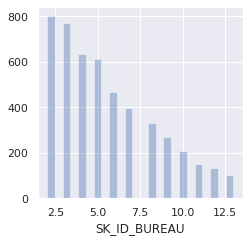

In [ ]:
# Bureau - BUREAU rows under CURR
hcdb.display_relation(train_il, right_df_name='bureau', size_val=6)

CREDIT_ACTIVE  ...  STATUS
SK_ID_CURR SK_ID_BUREAU MONTHS_BALANCE                ...        
102875     5052785      -7                    Active  ...       0
                        -6                    Active  ...       0
                        -5                    Active  ...       X
           5052791      -75                   Closed  ...       0
                        -74                   Closed  ...       0
                        -73                   Closed  ...       X
           5052793      -62                   Closed  ...       0
                        -61                   Closed  ...       0
                        -60                   Closed  ...       X
           5052795      -38                   Closed  ...       0
                        -37                   Closed  ...       0
                        -36                   Closed  ...       X
           5052797      -2                    Active  ...       0
                        -1                    Active  ...       0
                         0                    Active  ...       X

[15 rows x 4 columns]

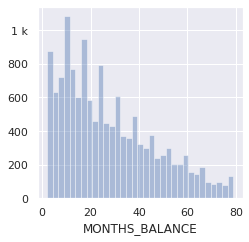

In [ ]:
# Bureau Balance - BALANCE rows under BUREAU
hcdb.display_relation(train_il, df_name='bureau', right_df_name='bureau_balance')

TARGET  AMT_CREDIT_l  ...  AMT_APPLICATION  AMT_CREDIT_r
SK_ID_CURR SK_ID_PREV                        ...                               
100003     1810518          0    1293502.50  ...        900000.00    1035882.00
           2396755          0    1293502.50  ...         68809.50      68053.50
           2636178          0    1293502.50  ...        337500.00     348637.50
100026     1252218          0     497520.00  ...        132345.00     132345.00
           1701107          0     497520.00  ...             0.00          0.00
           1772508          0     497520.00  ...        675000.00     744498.00
100050     1794209          0     746280.00  ...        180000.00     180000.00
           1997429          0     746280.00  ...             0.00          0.00
           2243464          0     746280.00  ...        153598.50     153598.50
100051     1168900          0     661702.50  ...        136620.00     152068.50
           2067446          0     661702.50  ...             0.00          0.00
           2499893          0     661702.50  ...             0.00          0.00
100056     1636219          0    1506816.00  ...        223920.00     201528.00
           1826250          0    1506816.00  ...        135000.00     142425.00
           1874778          0    1506816.00  ...        405000.00     506038.50

[15 rows x 6 columns]

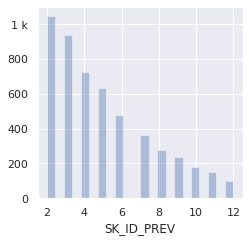

In [ ]:
# Previous Application - PREV rows under CURR
hcdb.display_relation(train_il, right_df_name='previous_application')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,,,TARGET,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_CREDIT_LIMIT_ACTUAL
SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,,,,


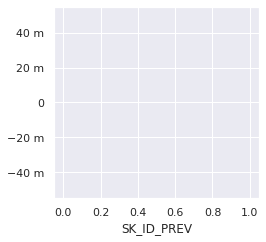

In [ ]:
# Credit Card - PREV rows under CURR
hcdb.display_relation(train_il, right_df_name='credit_card_balance')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TARGET  ...  AMT_CREDIT_LIMIT_ACTUAL
SK_ID_CURR SK_ID_PREV MONTHS_BALANCE          ...                         
100006     1489396    -6                   0  ...                   270000
                      -5                   0  ...                   270000
                      -4                   0  ...                   270000
                      -3                   0  ...                   270000
                      -2                   0  ...                   270000
                      -1                   0  ...                   270000
100441     1420482    -6                   0  ...                    90000
                      -5                   0  ...                    90000
                      -4                   0  ...                    90000
                      -3                   0  ...                    90000
                      -2                   0  ...                    90000
                      -1                   0  ...                    90000
100531     1211524    -6                   0  ...                    45000
                      -5                   0  ...                    45000
                      -4                   0  ...                    45000

[15 rows x 4 columns]

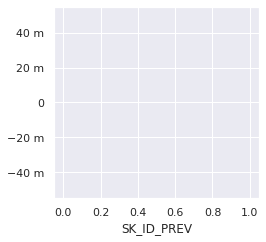

In [ ]:
# Credit Card - All rows under CURR and PREV
hcdb.display_relation(train_il, right_df_name='credit_card_balance', size_val=6, levels=1)

TARGET  ...  CNT_INSTALMENT
SK_ID_CURR SK_ID_PREV MONTHS_BALANCE          ...                
100025     1271192    -68                  0  ...            6.00
                      -67                  0  ...            6.00
                      -66                  0  ...            6.00
                      -65                  0  ...            6.00
                      -64                  0  ...            6.00
                      -63                  0  ...            6.00
100029     2662898    -11                  0  ...            6.00
                      -10                  0  ...            6.00
                      -9                   0  ...            6.00
                      -8                   0  ...            6.00
                      -7                   0  ...            4.00
                      -6                   0  ...            4.00
100030     2179840    -12                  0  ...            6.00
                      -11                  0  ...            6.00
                      -10                  0  ...            6.00

[15 rows x 4 columns]

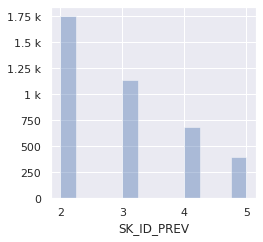

In [ ]:
# POS Cash - All rows under CURR and PREV
hcdb.display_relation(train_il, right_df_name='POS_CASH_balance', size_val=6, levels=1)

TARGET  ...  AMT_PAYMENT
SK_ID_CURR SK_ID_PREV NUM_INSTALMENT_NUMBER          ...             
100003     2636178    1                           0  ...     64567.66
                      2                           0  ...     64567.66
                      3                           0  ...     64567.66
                      4                           0  ...     64567.66
                      5                           0  ...     64567.66
                      6                           0  ...     64275.61
100008     1186888    1                           0  ...      8019.09
                      2                           0  ...      8019.09
                      3                           0  ...      8019.09
                      4                           0  ...      8019.09
                      5                           0  ...      8019.09
                      6                           0  ...      8003.48
100009     1193310    1                           0  ...     17341.61
                      2                           0  ...     17341.61
                      3                           0  ...     17341.61

[15 rows x 5 columns]

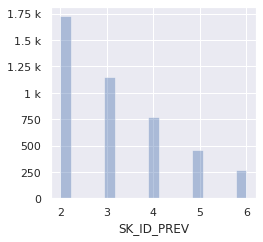

In [ ]:
# Installments - All rows under CURR and PREV
hcdb.display_relation(train_il, right_df_name='installments_payments', size_val=6, levels=1)

In [ ]:
# Check that processors are working
train_il.rename_col(df_name='credit_card_balance', col='SK_DPD', new_name='trySK')

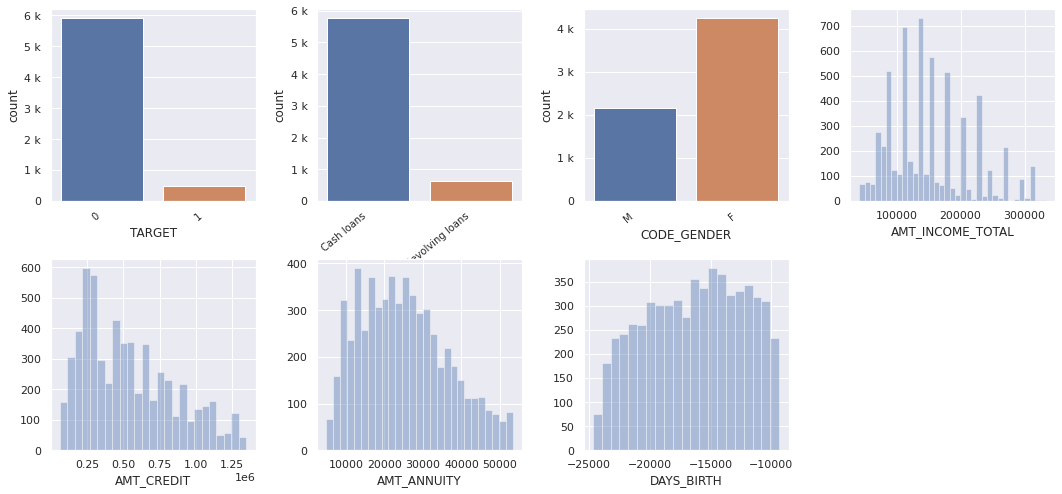

In [ ]:
DisplayData.data_distrib (train_il.df, ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER'], ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH'])

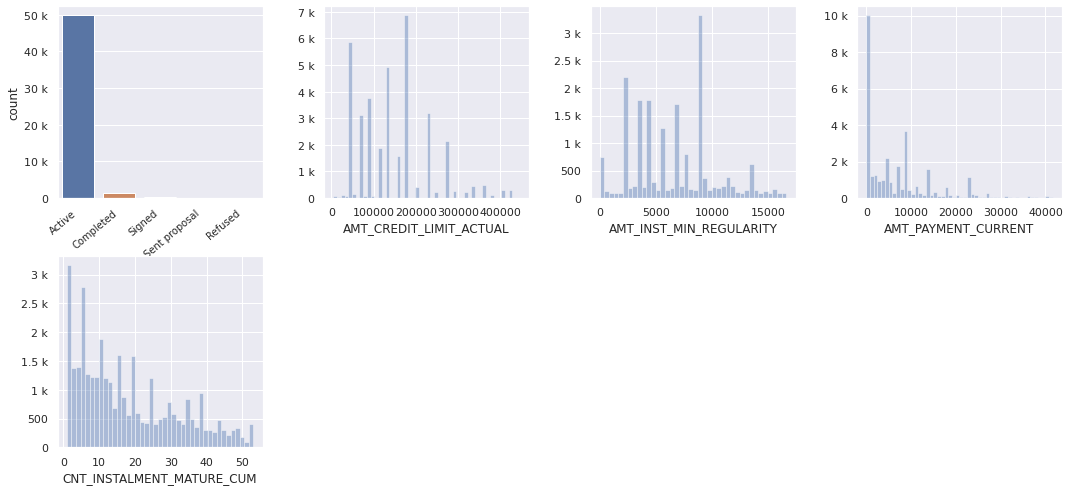

In [ ]:
DisplayData.data_distrib (train_il.credit_card_balance_df, train_il.credit_card_balance_fd['nominal'], train_il.credit_card_balance_fd['continuous'])

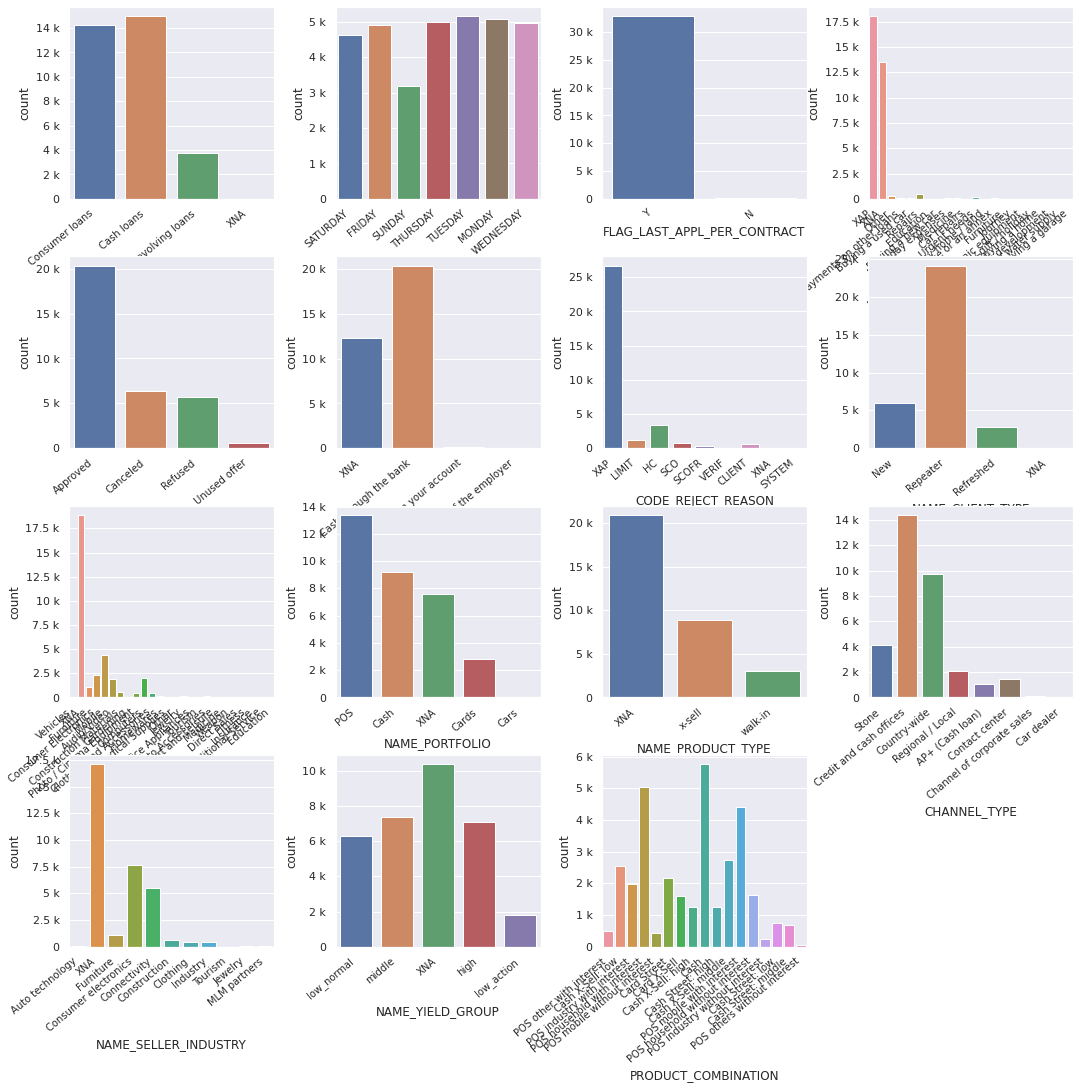

In [ ]:
DisplayData.data_distrib (train_il.previous_application_df, train_il.previous_application_fd['nominal'], [])

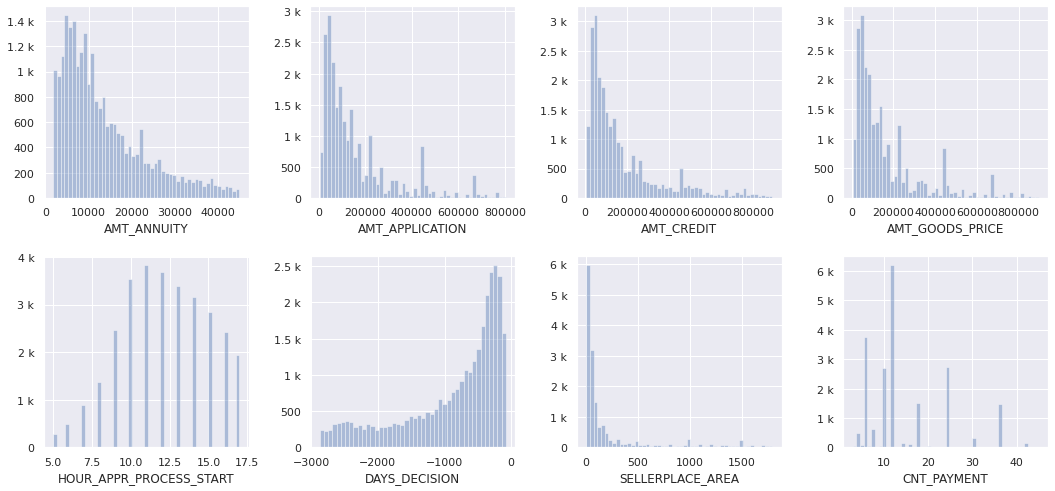

In [ ]:
DisplayData.data_distrib (train_il.previous_application_df, [], train_il.previous_application_fd['continuous'])

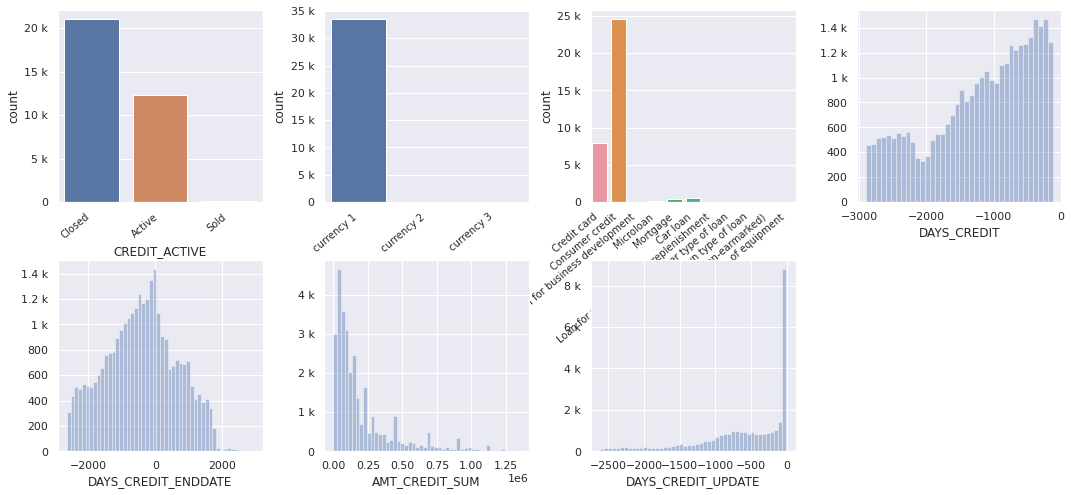

In [ ]:
DisplayData.data_distrib (train_il.bureau_df, train_il.bureau_fd['nominal'], train_il.bureau_fd['continuous'])

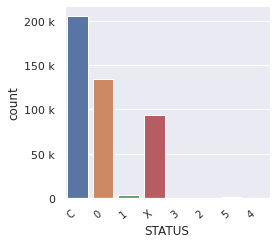

In [ ]:
DisplayData.data_distrib (train_il.bureau_balance_df, train_il.bureau_balance_fd['nominal'], train_il.bureau_balance_fd['continuous'])

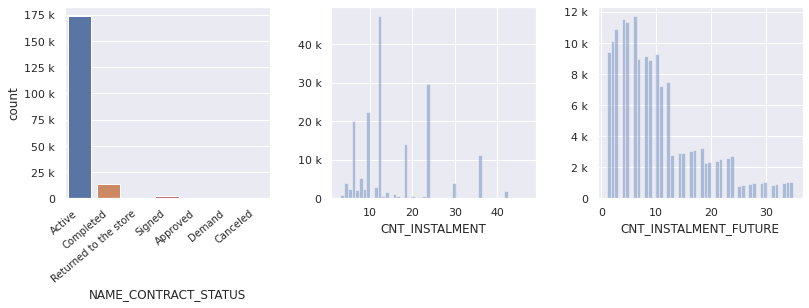

In [ ]:
DisplayData.data_distrib (train_il.POS_CASH_balance_df, train_il.POS_CASH_balance_fd['nominal'], train_il.POS_CASH_balance_fd['continuous'])

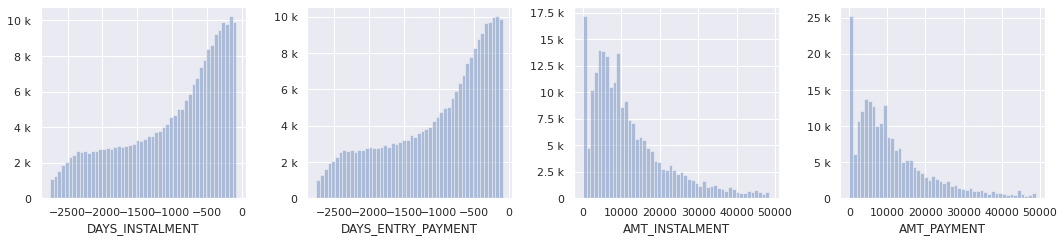

In [ ]:
DisplayData.data_distrib (train_il.installments_payments_df, train_il.installments_payments_fd['nominal'], train_il.installments_payments_fd['continuous'])

In [ ]:
thc_app = AppTabular(loss_type='bin_classif', metrics_cbs=[RocAucMetricsCB()])
thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, test_file_path, related_csv_paths, steps=['load'])
save_pickle(thc_app, pickle_dir, 'prep_data.pkl')

In [ ]:
thc_app = load_pickle(pickle_dir/'prep_data.pkl')
thc_app.load_data(None, None, None, None, steps=['post_load'])
save_pickle(thc_app, pickle_dir, 'proc_data.pkl')

In [ ]:
DebugRand.set_seed(0)
thc_app = load_pickle(pickle_dir/'proc_data.pkl')

thc_app.create_arch(emb_p=0.04, hidden_szs=[1000, 500], hidden_ps=[.001, .01])
thc_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
thc_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

thc_app.create_debug(use_dtr=True, track_batches_per_epoch=5000, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [ ]:
find_lr = True
if (find_lr):
  loop = thc_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100)

In [ ]:
#loop = thc_app.run_train(num_epochs=1, split_lr=[0.00035], weight_decay=0.2, one_cycle=True)
#loop = thc_app.run_train(num_epochs=1, split_lr=[0.01], weight_decay=0.01)
loop = thc_app.run_train(num_epochs=1, split_lr=[0.01], weight_decay=0.1, one_cycle=True)

epoch,tr_loss,smooth_loss,val_loss,roc_auc,time
0,0.352553,0.313901,0.294302,0.698287,00:00


In [ ]:
loop = thc_app.run_train(num_epochs=25, split_lr=[0.01], weight_decay=0.1, one_cycle=True)

(None, None)

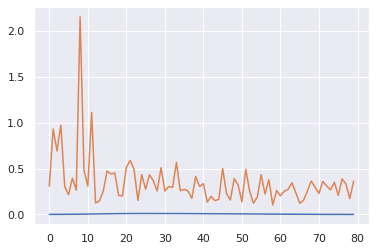

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df.head(3)
is_batch_df.head(2)
is_layer_df.head(2)

,run_id,num_epochs,row_type,epoch_id,num_tr_batches,num_val_batches,tr_loss,smooth_loss,val_loss,roc_auc,time
0,Run-20200825_125324,1.0,run,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-20200825_125324,NaN,epoch,0.0,80.0,20.0,0.357165,0.311746,0.278775,0.689535,00:00


,run_id,row_type,epoch_id,batch_id,iter,batch_type,pred,loss,lr,mom,betas_2,eps,weight_decay,amsgrad
2,Run-20200825_125324,batch,0.0,0-0,0.0,train,-13.883158,0.824985,0.000400,0.950000,0.99,1.000000e-08,0.1,False
3,Run-20200825_125324,batch,0.0,0-1,1.0,train,-13.747836,1.002118,0.000441,0.949572,0.99,1.000000e-08,0.1,False


""


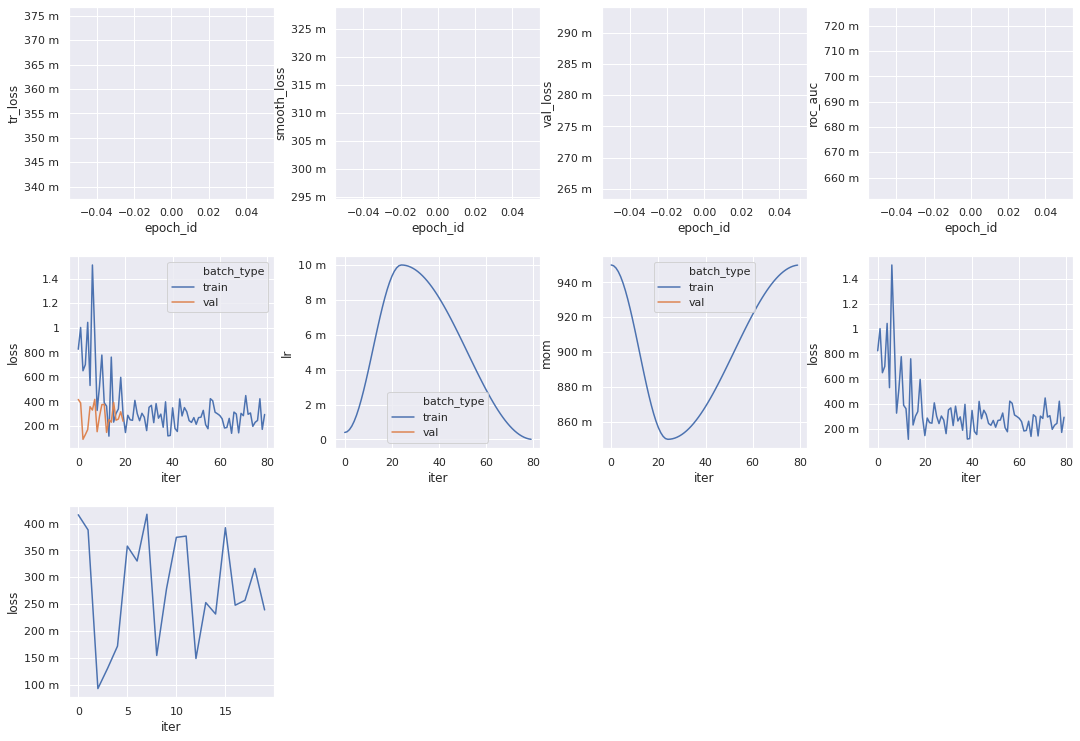

In [ ]:
loop.dtr.pd.display_metrics(is_run_df, is_batch_df, app_metrics=['roc_auc'])

In [ ]:
!rm -r tbtry

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir tbtry

In [ ]:
last_good_run = '27Aug'
good_app = load_pickle(hist_path/f'{last_good_run}_proc_data.pkl')
thc_app.db.compare_db(thc_app.db, good_app.db)

In [ ]:
loop.dtr.load_run(hist_path/f'{last_good_run}_run.pkl')
_, good_batch_df, good_layer_df, _ = loop.dtr.pd_results()

loop.dtr.pd.compare_batch_results(is_batch_df, good_batch_df)
if ((len(is_layer_df) > 0) and (len(good_layer_df) > 0)):
  loop.dtr.pd.compare_activation_results(is_layer_df, good_layer_df)
  loop.dtr.pd.compare_param_results(is_layer_df, good_layer_df)

In [ ]:
#good_run = None
good_run = '27Aug'
if (good_run):
  debug_path.mkdir(exist_ok=True)
  thc_app._arch.save_weights(debug_path/'arch_trained_wgts.mdl')

  hist_path.mkdir(exist_ok=True)
  save_pickle(thc_app, hist_path, f'{good_run}_proc_data.pkl')
  loop.dtr.save_run(hist_path/f'{good_run}_run.pkl')

**Evaluate different Settings**

In [ ]:
arch_def={'hidden_szs': [1000, 500], 'hidden_ps': [.001, .01], 'emb_p': .04}
train_def={'split_lr': [0.01], 'weight_decay': 0.1, 'one_cycle': True}
arch_options=[
          {'hidden_szs': [1500, 1000, 500], 'hidden_ps': [.001, .001, .01]},
          {'hidden_szs': [2000, 1500, 1000], 'hidden_ps': [.001, .001, .01]},
          {'hidden_szs': [2000, 1500, 1000, 500], 'hidden_ps': [.001, .001, .01, .01]},
          {'hidden_szs': [1000, 1000, 1000, 500, 500], 'hidden_ps': [.001, .001, .001, .01, .01]},
]
train_options=[
           {'weight_decay': 0.05},
           {'weight_decay': 0.08},
           {'weight_decay': 0.12},
           {'weight_decay': 0.15},
           {'weight_decay': 0.2},
]

def run_settings(self, arch_def, arch_options, train_def, train_options):
  # The 'options' override the 'def' settings. Each run experiment varies one variable
  # at a time as we don't want to try all combinations of all variables. So we vary
  # only the arch settings or the train settings in each run
  arch_all = [{}] + arch_options + [arch_def] * len(train_options)
  train_all = [{}] + [train_def] * len(arch_options) + train_options
  
  # Go through run experiments for each setting
  for i, (arch, train) in enumerate(zip(arch_all, train_all)):
    # Merge the given settings with the default settings
    arch_stgs = {**arch_def, **arch}
    train_stgs = {**train_def, **train}
    print (f'settings_{i}', arch_stgs, train_stgs)

    # Create arch with the given arch settings
    fix_seeds(0)
    self.create_arch(**arch_stgs)
    self.create_debug(use_dtr=True, track_batches_per_epoch=15000, disp_tb=False, disp_pd=False, debug_bkwd=False, debug_fwd=False, abort_iter=0)

    # Do a training run with the given training settings
    DebugRand.set_seed(0)
    loop = self.run_train(num_epochs=4, **train_stgs)

    # Merge all settings and convert the values to strings. This way list values don't
    # get filtered out when generating pd_results from the dtr
    stgs_all = {**arch_stgs, **train_stgs}
    stgs_all = {k:str(v) for k, v in stgs_all.items()}
    loop.dtr.update_run(stgs_all)

    # Save the run
    loop.dtr.save_run(hist_path/f'settings_{i}.pkl')

thc_app = load_pickle(pickle_dir/'proc_data.pkl')
run_settings(thc_app, arch_def, arch_options, train_def, train_options)

In [ ]:
!rm -r tbtry

In [ ]:
def compare_settings():
  # Get all saved run files in the directory
  rfs = [rf for rf in hist_path.iterdir()]
  #list(p.glob('**/*.py'))

  # Settings from all the runs will be merged in a single df
  stgs_df = pd.DataFrame()

  # Load each run file
  dtr = DebugTracker(disp=(True, True))
  for rf in rfs:
    dtr.load_run(rf)

    # Get the rows with run settings and merge it into the common df
    # !!!!!!!! pd_results() should return separate run_df and epoch_df
    run_df, _, _, _ = dtr.pd_results()
    run_df = run_df[run_df['row_type'] == 'run']
    stgs_df = stgs_df.append(run_df)

    # Display results for the run on Tensorboard
    dtr.tb_saved_results()

  return stgs_df
  
compare_settings()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir tbtry

**Compare timing with Fastai**

In [ ]:
fai_df = thc_app.db.all_rows.df
cat_vars = thc_app.db.all_rows._categorical_cols()
cont_vars = thc_app.db.all_rows._continuous_cols()
dep_var = thc_app.db.all_rows._target_cols()
path=data_path

from fastai.tabular import *
procs=[FillMissing, Categorify, Normalize]

In [ ]:
def tryit():
  db.set_trace()
  faidata = (TabularList.from_df(fai_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var)
                .databunch(bs=64))
  print(faidata.train_dl.sampler)
  return faidata

faidata = tryit()

In [ ]:
learn = tabular_learner(faidata, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        metrics=AUROC(), callback_fns=[])
learn.lr_find()
learn.recorder.plot()

In [ ]:
def tryit():
  db.set_trace()
  learn.lr_find()

tryit()

In [ ]:
def tryit():
  db.set_trace()
  learn.fit_one_cycle(1, 1e-3, wd=0.2)
  #learn.fit(1, 1e-3, wd=0.2)

tryit()

**Timing Performance**

In [ ]:
! pip install line_profiler
%load_ext line_profiler

In [ ]:
%lprun -f Trainer._tr_batch -f Tabular.forward thc_app.run_train(num_epochs=1, weight_decay=0.01)

In [ ]:
%lprun -f TabularHomeCreditDataBundle._prepare_rollup -f TabularHomeCreditDataBundle._prepare_pa_rollup thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, test_file_path, related_csv_paths, steps=['load'])

**Old Model**

In [ ]:
thc_app = AppTabular(loss_type='bin_classif', metrics_cbs=[RocAucMetricsCB()])
#thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, test_file_path, related_csv_paths)
thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, None, related_csv_paths)
thc_app.create_arch()
thc_app.create_debug(use_dtr=False, track_batches_per_epoch=5, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)
loop = thc_app.run_train(num_epochs=1)

In [ ]:
inps, outs, targs = is_app.run_predict()
is_app.db.display_results(inps, targs, outs)

**Old**

In [ ]:
kaggle_data_type = 'competitions'
kaggle_data_name = 'home-credit-default-risk'
root_path = Path.cwd()

data_path = root_path/'homecredit'
full_main_file_path = data_path/'application_train.csv'
full_test_file_path = data_path/'application_test.csv'
full_bureau_path = data_path/'bureau.csv'
full_bureau_balance_path = data_path/'bureau_balance.csv'
full_pa_path = data_path/'previous_application.csv'
full_cc_balance_path = data_path/'credit_card_balance.csv'
full_pos_balance_path = data_path/'POS_CASH_balance.csv'
full_installment_path = data_path/'installments_payments.csv'
full_related_csv_paths = [full_bureau_path, full_bureau_balance_path, full_pa_path, full_cc_balance_path, full_pos_balance_path, full_installment_path]

g_data_path = Path(gd_path) / 'data' / 'homecredit_6400'
subset_main_file_path = g_data_path/'application_train.csv'
subset_test_file_path = g_data_path/'application_test.csv'
subset_bureau_path = g_data_path/'bureau.csv'
subset_bureau_balance_path = g_data_path/'bureau_balance.csv'
subset_pa_path = g_data_path/'previous_application.csv'
subset_cc_balance_path = g_data_path/'credit_card_balance.csv'
subset_pos_balance_path = g_data_path/'POS_CASH_balance.csv'
subset_installment_path = g_data_path/'installments_payments.csv'
subset_related_csv_paths=[subset_bureau_path, subset_bureau_balance_path, subset_pa_path, subset_cc_balance_path, subset_pos_balance_path, subset_installment_path]

pickle_dir = root_path/'pickle'

In [ ]:
load_full = False
if (load_full):
  main_file_path = full_main_file_path
  test_file_path = full_test_file_path
  related_csv_paths = full_related_csv_paths
else:
  main_file_path = subset_main_file_path
  test_file_path = subset_test_file_path
  related_csv_paths = subset_related_csv_paths

In [ ]:
import types
import inspect
import torch.nn.functional as F

class WaitMetricsCB(Callback):
  def __init__(self, metric_dict):
    avg_metric_dict = {}
    for name, metric in metric_dict.items():
      if (inspect.isfunction(metric)):
        avg_metric_dict.update({name: metric})
      elif (inspect.isclass(metric)):
        pass

    avg_metric = AverageMetricsCB(avg_metric_dict)

def fart():
      if (type(metric) == types.FunctionType):
        isinstance(x, types.FunctionType) \
        or isinstance(x, types.BuiltinFunctionType)
        pass

from sklearn.metrics import roc_auc_score
class WaitRocAucMetricsCB(Callback):
  # ----------------------------
  # Reset all metrics at the beginning of each epoch
  # ----------------------------   
  def begin_epoch(self, ctx):
    self.yhat = torch.Tensor([])
    self.yb = torch.Tensor([])

  # ----------------------------
  # Calculate validation metrics for each batch
  # ----------------------------   
  def after_val_loss(self, ctx):
    #db.set_trace()
    yhat = torch.sigmoid(ctx.yhat)
    #yhat = F.softmax(ctx.yhat, dim=1)[:,-1]
    self.yhat = torch.cat((self.yhat, yhat.cpu()))
    self.yb = torch.cat((self.yb, ctx.yb.cpu()))

  # ----------------------------
  # Print results at the end of each epoch
  # ----------------------------   
  def end_epoch(self, ctx):
    #db.set_trace()  
    roc_score = roc_auc_score(self.yb.numpy(), self.yhat.numpy())
    print (roc_score)
  
#----------------------------------------------------
# Callback to calculate training and validation metrics
# We are given a dictionary of metric names and metric functions {'accuracy': accuracy_fn, 'f1': f1_fn, ...}
#----------------------------------------------------
class WaitAverageMetricsCB(Callback):
  def __init__(self, metric_dict):
    self.metric_dict = metric_dict
    self._reset()
  
  # ----------------------------
  # Reset all our metrics to 0
  # ----------------------------   
  def _reset(self):
    # Reset training and validation metrics
    # Training metrics are [metric1_tr_value, metric2_tr_value, ...]
    # Similarly, validation metrics are [metric1_val_value, metric2_val_value, ...]
    self.metrics_tr = len(self.metric_dict) * [0.]
    self.metrics_val = len(self.metric_dict) * [0.]

    # Reset total training loss and total validation loss
    self.tot_loss_tr = 0.
    self.tot_loss_val = 0.
  
  # ----------------------------
  # Format the metric values for training or validation. Calculate the average
  # value of that metric by dividing by number of iterations
  # ----------------------------   
  def _results(self, tot_loss, metrics, nv):
    # Format the loss value
    res = ['{0:.6f}'.format(tot_loss/nv)]

    # Format the metric values
    for i, metric_name in enumerate(self.metric_dict.keys()):
      res += ['{0:.6f}'.format(metrics[i]/nv)]

    return (res)

  # ----------------------------
  # Calculate values of each metric using the metric function and accumulate it
  # by adding it to the sum of all previous values of that metric 
  # ----------------------------   
  def _calc_metrics(self, metrics, ctx):
    for i, metric_fn in enumerate(self.metric_dict.values()):
      metrics[i] += metric_fn(ctx.yhat, ctx.yb)

  # ----------------------------
  # Print headers for all the result columns
  # ----------------------------   
  def begin_fit(self, ctx):
    # ['loss', 'metric1', 'metric2', ..]
    metric_names = ['loss'] + list(self.metric_dict.keys())
    # ['epoch', ...metric names..., 'time']
    headers = ['epoch'] + [f'train_{n}' for n in metric_names] + [f'valid_{n}' for n in metric_names] + ['time']
    ctx.logger(headers)

  # ----------------------------
  # Reset all metrics at the beginning of each epoch
  # ----------------------------   
  def begin_epoch(self, ctx):
    self._reset()
    ctx.start_time = time.time()

  # ----------------------------
  # Calculate training metrics for each batch
  # ----------------------------   
  def after_tr_loss(self, ctx):
    with torch.no_grad():
      self.tot_loss_tr += ctx.loss
      self._calc_metrics(self.metrics_tr, ctx)

  # ----------------------------
  # Calculate validation metrics for each batch
  # ----------------------------   
  def after_val_loss(self, ctx):
    self.tot_loss_val += ctx.loss
    self._calc_metrics(self.metrics_val, ctx)

  # ----------------------------
  # Print results at the end of each epoch
  # ----------------------------   
  def end_epoch(self, ctx):  
    res = [str(ctx.i_epoch)]
    res += self._results(self.tot_loss_tr, self.metrics_tr, len(ctx.tr_dl))
    res += self._results(self.tot_loss_val, self.metrics_val, len(ctx.val_dl))
    res += [format_time(time.time() - ctx.start_time)]
    ctx.logger(res)
  

### Debug Val Loss

**Debug Val Callback**

In [ ]:
class Outlier():
  def __init__(self):
    self.row_id = []
    self.xbs = np.empty(shape=(0, 0))
    self.yhats = np.empty(shape=(0, 1))
    self.ybs = np.empty(shape=(0, 1))

class DebugVal(Callback):
  def __init__(self):
    self.tr_outlier = Outlier()
    self.val_outlier = Outlier()

  # ----------------------------
  # ----------------------------   
  def begin_epoch(self, ctx):
    self.accu_yhat = None
    self.accu_yb = None

  # ----------------------------
  # ----------------------------   
  def accu_tr(self, ctx):
    if (self.accu_yhat is None):
      self.accu_yhat = ctx.yhat.clone().detach()
      self.accu_yb = ctx.yb.clone().detach()
    else:
      self.accu_yhat = torch.cat((self.accu_yhat, ctx.yhat.detach()))
      self.accu_yb = torch.cat((self.accu_yb, ctx.yb.detach()))

  # ----------------------------
  # ----------------------------
  @staticmethod   
  def track_outlier(ctx, ol):
    if (ctx.loss < 1):
      return

    lg = ((ctx.yhat > 1e2) & (ctx.yb == 0.)) | ((ctx.yhat < -1e2) & (ctx.yb == 1.))
    if (lg.any()):
      lgi = lg.squeeze().nonzero(as_tuple=True)
      ol.row_id += (lgi[0] + ctx.i_batch * ctx.yhat.shape[0]).tolist()
      ol.yhats = np.concatenate((ol.yhats, ctx.yhat[lgi].cpu().numpy()), axis=0)
      ol.ybs = np.concatenate((ol.ybs, ctx.yb[lgi].cpu().numpy()), axis=0)
      if (ctx.xb.shape[1] != ol.xbs.shape[1]):
        ol.xbs = ol.xbs.reshape(-1, ctx.xb.shape[1])
      ol.xbs = np.concatenate((ol.xbs, ctx.xb[lgi].cpu().numpy()), axis=0)

  # ----------------------------
  # ----------------------------   
  def after_tr_loss(self, ctx):
    self.accu_tr(ctx)
    self.track_outlier(ctx, self.tr_outlier)

  # ----------------------------
  # ----------------------------   
  def after_val_loss(self, ctx):
    self.track_outlier(ctx, self.val_outlier)

  # ----------------------------
  # ----------------------------   
  def end_epoch(self, ctx):
    pass

**Pickle Data**

In [ ]:
pickle_dir = root_path/'pickle'
pickle_file = 'hcapp.pkl'

In [ ]:
save_pickle(thc_app, pickle_dir, pickle_file)
new_app = load_pickle(pickle_dir/pickle_file)
new_app.n_cont

In [ ]:
# full_tr, sub100_tr, sub640_tr, sub640_trvl
save_pickle(thc_app.db.train_dl, pickle_dir, 'trdl.pkl')
thc_app.db.valid_dl = load_pickle(pickle_dir/'trdl.pkl')

**Save/Restore model**

In [ ]:
torch.manual_seed(0)
thc_app = AppTabular(loss_type='bin_classif', metrics_cbs=[RocAucMetricsCB()])
thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, None, related_csv_paths)
save_pickle(thc_app, pickle_dir, pickle_file)
thc_app.create_arch()
loop = thc_app.run_train(num_epochs=1)
save_weights(thc_app._arch, pickle_dir/'hcarch.mdl')

In [ ]:
torch.manual_seed(0)
thc_app = load_pickle(pickle_dir/pickle_file)
thc_app.create_arch()
#load_weights(thc_app._arch, pickle_dir/'hcarch.mdl')
loop = thc_app.run_train(num_epochs=1)

**Dataset Tr + Val - No Split**

In [ ]:
class DebugHCDB(TabularHomeCreditDataBundle):
  def __init__(self, *args):
    super().__init__(*args)
    #self.split_params = {'split_procedure': None, 'train_ratio': 0.8, 'valid_ratio': 0.2}
    self.split_params = {'split_procedure': None}

In [ ]:
thc_app = AppTabular(loss_type='bin_classif', metrics_cbs=[RocAucMetricsCB()])
thc_app.load_data(DebugHCDB, main_file_path, None, related_csv_paths)
save_pickle(thc_app, pickle_dir, 'full_trvl')

In [ ]:
torch.manual_seed(0)
thc_app = load_pickle(pickle_dir/'full_trvl')
thc_app.db.valid_dl = thc_app.db.train_dl
thc_app.create_arch()
#load_weights(thc_app._arch, pickle_dir/'hcarch.mdl')
loop = thc_app.run_train(num_epochs=1)
save_weights(thc_app._arch, pickle_dir/'hcarch.mdl')

In [ ]:
save_pickle(loop.cbs[-1].val_outlier, pickle_dir, 'val_outlier')

**Dataset with same N outliers for both Tr and Val**, and pre-trained model

In [ ]:
torch.manual_seed(0)
thc_app = load_pickle(pickle_dir/'full_trvl')

val_outlier = load_pickle(pickle_dir/'val_outlier')
n_rows = 20
thc_app.db.train_dl.dataset.x.arr = val_outlier.xbs[:n_rows]
thc_app.db.train_dl.dataset.x.items = list(range(n_rows))
thc_app.db.train_dl.dataset.y.arr = val_outlier.ybs[:n_rows]
thc_app.db.train_dl.dataset.y.items = list(range(n_rows))
#thc_app.db.train_dl.batch_size = 1
thc_app.db.valid_dl = thc_app.db.train_dl

thc_app.create_arch()
load_weights(thc_app._arch, pickle_dir/'hcarch.mdl')
loop = thc_app.run_train(num_epochs=1)

In [ ]:
loop.cbs[-1].accu_yhat, loop.cbs[3].yhat

In [ ]:
del thc_app, loop, val_outlier, tr_outlier, foox, debug_val_cb, loss_metrics_cb, tr_pred, tr_targ, val_pred, val_targ, recorder_cb
import gc
gc.collect()

**Loss on full epoch accumulated data** with both BCELoss and BCEWithLogitsLoss

In [ ]:
debug_val_cb = loop.cbs[-1]
debug_val_cb.accu_yhat.shape, debug_val_cb.accu_yb.shape

loss_metrics_cb = loop.cbs[3]
loss_metrics_cb.yhat.shape, loss_metrics_cb.yb.shape
print('\nTr and Val Loss, averaged across all batches')
loss_metrics_cb.value

tr_pred, tr_targ = debug_val_cb.accu_yhat, debug_val_cb.accu_yb
val_pred, val_targ = loss_metrics_cb.yhat, loss_metrics_cb.yb
print('\nTr Accumulated Loss for Epoch - Logits and Sigmoid')
nn.BCEWithLogitsLoss()(tr_pred, tr_targ), nn.BCELoss()(torch.sigmoid(tr_pred), tr_targ)
print('\nVal Accumulated Loss for Epoch - Logits and Sigmoid')
nn.BCEWithLogitsLoss()(val_pred, val_targ), nn.BCELoss()(torch.sigmoid(val_pred), val_targ)
print('\nLoss per batch, for first few batches')
recorder_cb = loop.cbs[1]
recorder_cb.losses[:10]

In [ ]:
def per_line_loss(yhat, yb):
  for yhi, ybi in zip(yhat, yb):
    print (f'{nn.BCELoss()(torch.sigmoid(yhi), ybi).item():0.2f}, {nn.BCEWithLogitsLoss()(yhi, ybi).item():0.2f}, {yhi.item():0.2f}, {ybi.item():0.2f}')

# Per line validation loss
per_line_loss(loss_metrics_cb.yhat[:20], loss_metrics_cb.yb[:20])

**Training - Get xb and yhat for large outlier losses**

In [ ]:
tr_outlier = loop.cbs[-1].tr_outlier
foox = pd.DataFrame(tr_outlier.xbs)
foox

**Validation - Get xb and yhat for large outlier losses**

In [ ]:
# Get outlier rows which resulted in large loss
val_outlier = loop.cbs[-1].val_outlier
foox = pd.DataFrame(val_outlier.xbs)
foox

In [ ]:
# Get outlier rows from original df
thc_app.db.valid_ds.x.df.iloc[val_outlier.row_id]

In [ ]:
# Get loss amount of the outliers
nn.BCELoss()(torch.sigmoid(tensor(val_outlier.yhats)), tensor(val_outlier.ybs))
nn.BCEWithLogitsLoss()(tensor(val_outlier.yhats), tensor(val_outlier.ybs))

**Pass an outlier through the model to see what output it produces**

In [ ]:
val_outlier.yhats[:2]

In [ ]:
thc_app._arch.model(tensor(val_outlier.xbs[:2], device='cuda'))

**DTR Debug with fwd and bkwd**

In [ ]:
torch.manual_seed(0)
thc_app = AppTabular(loss_type='bin_classif', metrics_cbs=[RocAucMetricsCB()])
thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, None, related_csv_paths)
thc_app.create_arch()
loop = thc_app.run_train(num_epochs=1, use_dtr=True)

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df
is_layer_df

In [ ]:
is_layer_df[is_layer_df['step_type'] == 'activation']

**Debug Val Loss**

In [ ]:
loop = thc_app.run_train(num_epochs=1)

In [ ]:
hcdb = TabularHomeCreditDataBundle(main_file_path, test_csv_path=test_file_path, related_csv_paths=related_csv_paths)
#train_il = hcdb._load(**hcdb.load_params)
train_il = hcdb.process(steps=['load'])

In [ ]:
train_il.df[train_il.df['CC_MONTHS_BALANCE_max_Signed_max'].notnull()]['CC_MONTHS_BALANCE_max_Signed_max']

In [ ]:
train_il.df['CC_MONTHS_BALANCE_max_Signed_max'] = train_il.df['CC_MONTHS_BALANCE_max_Signed_max'].fillna(0.)

In [ ]:
train_il.df['CC_MONTHS_BALANCE_max_Signed_max']

In [ ]:
train_il.df['CC_MONTHS_BALANCE_max_Signed_max'].astype('float64').std()

In [ ]:
thc_app.db.convert_state_x['Std_CC_MONTHS_BALANCE_max_Signed_max']

In [ ]:
thc_app.db.valid_ds.x.df[thc_app.db.valid_ds.x.df['CC_MONTHS_BALANCE_max_Signed_max'] != 0]['CC_MONTHS_BALANCE_max_Signed_max']

In [ ]:
(-92. + 39.) / (1e-7 + 0.)

In [ ]:
loop.cbs[-1].row_id

In [ ]:
foox = pd.DataFrame(loop.cbs[-1].xbs)

In [ ]:
def fooxd():
  for col in foox.columns:
    mask = (foox[col] > 1e2) | (foox[col] < -1e2)
    if (mask.any()):
      print (col, foox.loc[mask, col])

  for row in range(len(foox)):
    for j, col in enumerate(foox.columns):
      val = foox.iloc[row, j]
      if ((val > 1e2) | (val < -1e2) | ((val < 1e-3) & (val > -1e-3))):
        print ('here', row, j)

fooxd()

In [ ]:
foot = foox.transpose()
foom = foot[(foot[0] > 1e2) | (foot[1] > 1e2) | (foot[2] > 1e2) | (foot[0] < -1e2) | (foot[1] < -1e2) | (foot[2] < -1e2)]
foom

In [ ]:
fooc = thc_app.db.valid_ds.x._categorical_cols() + thc_app.db.valid_ds.x._continuous_cols()
foocl = list((fooc[13], fooc[81], fooc[112], fooc[118], fooc[125]))
foocl

In [ ]:
thc_app.db.valid_ds.x.df[foocl]

In [ ]:
def dbtr():
  trdf = thc_app.db.train_ds.x.df
  for col in thc_app.db.valid_ds.x._continuous_cols():
    if (((trdf[col] > 1e3) | (trdf[col] < -1e3)).any()):
      print(col)

    if (thc_app.db.convert_state_x[f'Std_{col}'] < 1e-4):
      print (col, thc_app.db.convert_state_x[f'Std_{col}'])
    
dbtr()

In [ ]:
thc_app.db.train_ds.x.df[(thc_app.db.train_ds.x.df['PA_PCT_CREDIT_max_Refused'] > 1e2) | (thc_app.db.train_ds.x.df['PA_PCT_CREDIT_max_Refused'] < -1e2)]['PA_PCT_CREDIT_max_Refused']

In [ ]:
thc_app.db.valid_ds.x.df[(thc_app.db.valid_ds.x.df['PA_PCT_GOODS_PRICE_min_Approved'] > 1e2) | (thc_app.db.valid_ds.x.df['PA_PCT_GOODS_PRICE_min_Approved'] < -1e2)]['PA_PCT_GOODS_PRICE_min_Approved']

In [ ]:
pred = tensor(
       [[ 1.6094e+01],
        [ 5.1216e-01],
        [-9.5367e+00],
        [ 2.4377e+01],
        [ 3.5349e+01],
        [ 2.5894e+01],
        [ 3.1808e+01],
        [ 1.8592e-01],
        [-2.8377e+00],
        [-9.0343e+00],
        [ 1.5208e+01],
        [ 4.8932e+00],
        [-5.4581e+00],
        [ 1.8190e+01],
        [ 1.0950e+01],
        [ 1.7572e+01],
        [-2.2359e+01],
        [ 2.0425e+01],
        [ 1.9340e+02],
        [ 8.5044e-01]])

targ = tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

print (F.binary_cross_entropy_with_logits(pred, targ), nn.BCEWithLogitsLoss()(pred, targ), nn.BCELoss()(torch.sigmoid(pred), targ))

pred, targ = pred.double(), targ.double()
print (F.binary_cross_entropy_with_logits(pred, targ), nn.BCEWithLogitsLoss()(pred, targ), nn.BCELoss()(torch.sigmoid(pred), targ))

pred, targ = pred[:2], targ[:2]
print (F.binary_cross_entropy_with_logits(pred, targ), nn.BCEWithLogitsLoss()(pred, targ), nn.BCELoss()(torch.sigmoid(pred), targ))

predl = tensor(
       [[ 1.6094e+01],
        [ 5.1216e-01],
        [-9.5367e+00],
        [ 2.4377e+01],
        [ 3.5349e+01],
        [ 2.5894e+12],
        [ 3.1808e+01],
        [ 1.8592e-01],
        [-2.8377e+00],
        [-9.0343e+00],
        [ 1.5208e+01],
        [ 4.8932e+00],
        [-5.4581e+00],
        [ 1.8190e+01],
        [ 1.0950e+07],
        [ 1.7572e+06],
        [-2.2359e+01],
        [ 2.0425e+01],
        [ 1.9340e+02],
        [ 8.5044e-01]])

**End Val Loss**

### Home Credit Todo Later

**My Data, Aguiar LightGBM Model**

In [ ]:
hcdb = TabularHomeCreditDataBundle(main_file_path, test_file_path, related_csv_paths=related_csv_paths)
#train_il = hcdb._load(**hcdb.load_params)
train_il = hcdb.process(steps=['load'])
train_il.test_rows.df['TARGET']=np.nan
train_il.df = train_il.df.append(train_il.test_rows.df)
foo_cat_cols = train_il._categorical_cols()
train_il.df = pd.get_dummies(train_il.df, columns=foo_cat_cols, dummy_na=True)
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(train_il.df, num_folds=2, stratified=False, debug=True)

**Aguiar Data, My Model**

In [ ]:
thc_app = AppTabular()
#thc_app.load_data(TabularHomeCreditDataBundle, main_file_path, test_file_path, related_csv_paths)
thc_app.load_data(TabularHomeCreditDataBundle, subset_main_file_path, None, None)
thc_app.create_arch()
loop = thc_app.run_train(num_epochs=1, use_roc=True)

**Debug**

In [ ]:
pd.describe_option('display')
with pd.option_context('mode.use_inf_as_na', True):
    df = df.dropna(subset=['col1', 'col2'], how='all')
pd.set_option('use_inf_as_na', True)
df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
np.isfinite(X_train).all()

np.isnan(X_train).any()

df.replace([np.inf, -np.inf], np.nan)

pd.describe_option('mode')

In [ ]:
thc_app.db.all_rows, thc_app.db.train_rows, thc_app.db.valid_rows, thc_app.db.test_rows
thc_app.db.train_ds.x.related_dfs
thc_app.db.train_ds.x.df.memory_usage().sum() / 1024 / 1024
print ('\n')
thc_app.db.train_ds.y.df.memory_usage().sum() / 1024 / 1024
print ('\n')
thc_app.db.valid_ds.x.df.memory_usage().sum() / 1024 / 1024
print ('\n')
thc_app.db.valid_ds.y.df.memory_usage().sum() / 1024 / 1024
print ('\n')

In [ ]:
type(thc_app.db.train_ds.x.items[0]), sys.getsizeof(thc_app.db.train_ds.x.items[0])

In [ ]:
del thc_app
thc_app = None
import gc
gc.collect()

In [ ]:
train_ds, train_dl = thc_app.db.train_ds, thc_app.db.train_dl
train_ds.x.df
train_x, train_y = next(iter(train_dl))
type(train_x), type(train_y), train_y.shape, len(train_x), train_x[0].shape, train_x[1].shape
train_y[:10], train_x[0][:3], train_x[1][:3]

In [ ]:
thc_app._arch.model

**Kaggle Aguiar**

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(main_file_path, nrows= num_rows)
    test_df = pd.read_csv(test_file_path, nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    #df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(related_csv_paths[0], nrows = num_rows)
    bb = pd.read_csv(related_csv_paths[1], nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(related_csv_paths[2], nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(related_csv_paths[4], nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(related_csv_paths[5], nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(related_csv_paths[3], nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def k_main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df
    #with timer("Run LightGBM with kfold"):
    #    feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)


In [ ]:
fook_df = k_main(debug=False)

In [ ]:
fook_df.sample()

In [ ]:
train_il.fook_df = fook_df
hcdb.display_metadata(train_il, 'fook')

In [ ]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def previous_applications(file_path, num_rows = None, nan_as_category = True):
    prev = pd.read_csv(file_path, nrows = num_rows)

    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    return prev_agg

In [ ]:
def k_pa(file_path):
    prev = pd.read_csv(file_path)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    WAITnum_aggregations = {
        'AMT_APPLICATION': ['mean', 'min', 'max', 'sum'],
    }
    cat_aggregations = {}

    # Previous applications categorical features
    solo_cat_aggregations = {}
    for cat in cat_cols:
        solo_cat_aggregations[cat] = ['mean']
    prev_cat = prev.groupby('SK_ID_CURR').agg({**solo_cat_aggregations})
    prev_cat.columns = ['_'.join(col) for col in prev_cat.columns.values]

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = ['_'.join(col) for col in prev_agg.columns.values]
    #prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    return prev_cat

%time fook = k_pa(subset_pa_path)
fook.head(2)
len(fook.columns)

In [ ]:
def my_cat(df, index, cat_cols):
    concat_dfs = []
    # We want separate rolled up counts for each categorical column. Doing this in
    # a single pivot_table() (or crosstab()) call by passing the list of categorical
    # columns results in a deep multi-level column index with counts for all possible
    # combinations of those column values, which is not what we want. So we get counts
    # for one column at a time and concatenate them all into a single result df.
    for col in cat_cols:
      # Use crosstab since pivot_table doesn't support the normalise feature, 
      # which gives us percentage counts, by row
      indexes = [df[idx] for idx in index]
      df_count = pd.crosstab(indexes, df[col], normalize='index')
      df_count.columns = [f'{df_count.columns.name}_{val}' for val in df_count.columns.values]

      # Add to our list of count dfs
      concat_dfs.append(df_count)

    # Concatenate all our count dfs column-wise
    df_cat = pd.concat(concat_dfs, axis=1, verify_integrity=True)
    return df_cat

def my_cont(df, index, group_cols, agg_cont):
  #df = df.groupby(index).agg(agg_cont)
  df = df.pivot_table(index=index, columns=group_cols, aggfunc=agg_cont)
  df.columns = ['_'.join(col) for col in df.columns.values]
  return df

def my_cat_enc(df, index, cat_cols, nan_as_category = True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, columns= cat_cols, dummy_na= nan_as_category)

    new_columns = [c for c in df.columns if c not in original_columns]
    agg_cat = {}
    for cat in new_columns:
        agg_cat[cat] = ['mean']
    df_cat = df.groupby(index).agg(agg_cat)
    df_cat.columns = ['_'.join(col) for col in df_cat.columns.values]

    return df_cat

def my_pa(file_path):
  pa_df = pd.read_csv(file_path)
  pa_df = my_reduce_mem(pa_df, 'pa')

  pa_df['APP_CREDIT_PERC'] = pa_df['AMT_APPLICATION'] / pa_df['AMT_CREDIT']

  pa_agg_cat = ['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON',	
                  'NAME_CLIENT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE']
  WAITpa_agg_cat = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 
                'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 
                'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 
                'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
  pa_agg_cont = {
        # Annuity of previous application
        'AMT_ANNUITY': ['mean', 'min', 'max', 'sum'],
        # Credit asked for in previous application
        'AMT_APPLICATION': ['mean', 'min', 'max', 'sum'],
        # Final credit amount in previous application
        'AMT_CREDIT': ['mean', 'min', 'max', 'sum'],
        # Price of good that client asked for
        'AMT_GOODS_PRICE': ['mean', 'min', 'max', 'sum'],
        # Number of payment installments
        'CNT_PAYMENT': 'mean',
        # Number of days before current application, when previous application was decided
        'DAYS_DECISION': ['min', 'max']
        }
  WAITpa_agg_cont = {
        # Annuity of previous application
        'AMT_APPLICATION': ['mean', 'min', 'max', 'sum']
  }

  use_crosstab = 'roll'
  if (use_crosstab == 'my'):
    pa_df_cat = my_cat(pa_df, ['SK_ID_CURR'], pa_agg_cat)
  elif (use_crosstab == 'roll'):
    pa_df_cat = _my_roll_cat(None, pa_df, ['SK_ID_CURR'], pa_agg_cat)
  else:
    pa_df_cat = my_cat_enc(pa_df, ['SK_ID_CURR'], pa_agg_cat, nan_as_category = False)

  use_cont = 'roll'
  if (use_cont == 'groupby'):
    pass
    #pa_df = pa_df.groupby('SK_ID_CURR').agg(pa_agg_cont)
  elif (use_cont == 'my'):
    pa_df = my_cont(pa_df, ['SK_ID_CURR'], ['NAME_CONTRACT_STATUS'], pa_agg_cont)
  elif (use_cont == 'roll'):
    pa_df = _my_roll_cont(None, pa_df, ['SK_ID_CURR'], ['NAME_CONTRACT_STATUS'], pa_agg_cont)
  else:
    pa_df = pa_df.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_STATUS'], aggfunc=pa_agg_cont)
    pa_df.columns = ['_'.join(col) for col in pa_df.columns.values]

  return pa_df_cat

%time food = my_pa(subset_pa_path)
food.head(2)
len(food.columns)

In [ ]:
%lprun -f _my_roll_cat -f _my_roll_cont my_pa(full_pa_path)

**Timing**

In [ ]:
# Init Df with Train and Previous Appl (open both files, reduce mem and init df) - 16.8s
# Open CSV Previous Application 10.4s
#    Read CSV Previous Application 6s
#    Reduce mem Previous Application 4.4s
# Open CSV (read and reduce mem) Train - 6.5s
# Prepare Previous App rollup standalone - 3.53 min (all time is in Rollup)
#    Roll Cat - 2.45 min (all time in crosstab)
#    Roll Cont - 1.28 min (all time in pivot_table)
# Aguiar Previous App rollup standalone - 31s
#    Read CSV - 6s
#    One Hot - 2.6s
#    All groupby aggregations - 22s
# My_PA func
#    Only Pivot Table for continuous - 11s
#    Along with Crosstab with categorical - 37s
#    Along with Crosstab with categorical, all columns - 1.25 min
#    Along with Dummy + Groupby mean, all columns - 27s

In [ ]:
foo_rdf = TabularItemList.open_csv(full_pa_path)
foo_df = TabularItemList.open_csv(full_main_file_path)
foo_il = TabularItemList(items=None, df=foo_df, related_dfs={'previous_application': foo_rdf})
foo_hc = TabularHomeCreditDataBundle(None, None, None)

In [ ]:
! pip install line_profiler
%load_ext line_profiler

In [ ]:
%lprun -f previous_applications previous_applications(full_pa_path)

In [ ]:
  def _my_flatten_col_names(df):
    if (df.columns.nlevels > 1):
      df.columns = ['_'.join(col) for col in df.columns.values]
  
  # ----------------------------
  # Helper function to rollup categorical columns 
  # ----------------------------
  def _my_roll_cat(self, df, index, cat_cols):
    concat_dfs = []
    # We want separate rolled up counts for each categorical column. Doing this in
    # a single pivot_table() (or crosstab()) call by passing the list of categorical
    # columns results in a deep multi-level column index with counts for all possible
    # combinations of those column values, which is not what we want. So we get counts
    # for one column at a time and concatenate them all into a single result df.
    for col in cat_cols:
      # Use crosstab since pivot_table doesn't support the normalise feature, 
      # which gives us percentage counts, by row
      indexes = [df[idx] for idx in index]
      df_count = pd.crosstab(indexes, df[col], normalize='index')
      df_count.columns = [f'{df_count.columns.name}_{val}' for val in df_count.columns.values]

      # Add to our list of count dfs
      concat_dfs.append(df_count)

    # Concatenate all our count dfs column-wise
    df_cat = pd.concat(concat_dfs, axis=1, verify_integrity=True)
    return df_cat

  # ----------------------------
  # Helper function to rollup continuous columns 
  # ----------------------------
  def _my_roll_cont(self, df, index, group_cols, agg_cont):
    # Probably due to a Pandas bug, columns of type 'float16' result in a 
    # bizarre 'No Matching Signature' error. Converting to 'float32' gets rid
    # of the error
    for col in agg_cont.keys():
      if (df[col].dtype == 'float16'):
        df[col] = df[col].astype('float32')

    # Aggregate the continuous columns, optionally grouping by some categorical
    # columns. Then flatten the multi-index column names
    df_cont = df.pivot_table(index=index, columns=group_cols, aggfunc=agg_cont)
    _my_flatten_col_names(df_cont)
    return df_cont

In [ ]:
  pa_agg_cat = ['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON',	
                  'NAME_CLIENT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE']
  pa_agg_cont = {
        # Annuity of previous application
        'AMT_ANNUITY': ['mean', 'min', 'max', 'sum'],
        # Credit asked for in previous application
        'AMT_APPLICATION': ['mean', 'min', 'max', 'sum'],
        # Final credit amount in previous application
        'AMT_CREDIT': ['mean', 'min', 'max', 'sum'],
        # Price of good that client asked for
        'AMT_GOODS_PRICE': ['mean', 'min', 'max', 'sum'],
        # Number of payment installments
        'CNT_PAYMENT': 'mean',
        # Number of days before current application, when previous application was decided
        'DAYS_DECISION': ['min', 'max']
        }

%lprun -f TabularItemList._roll_cat -f TabularItemList._roll_cont foo_il.time_rollup(df_name='previous_application', index=['SK_ID_CURR'], group_cols=['NAME_CONTRACT_STATUS'], cat_cols=pa_agg_cat, agg_cont = pa_agg_cont)

**Bureau**

In [ ]:
remap_cat_dict = {
    'Active': 'Active',
    'Closed': 'Closed',
    'Sold': 'Closed',
}
train_il.remap_cat(df_name='bureau', col='CREDIT_ACTIVE', remap_dict=remap_cat_dict)

train_il.rollup(df_name='bureau', index=['SK_ID_CURR'], group_cols=['CREDIT_ACTIVE'],
       cat_cols=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'],
       agg_cont={'DAYS_CREDIT': ['mean', 'max'], 
                 'DAYS_CREDIT_ENDDATE': ['mean', 'max'], 
                 'AMT_CREDIT_SUM': ['mean', 'max'], 
                 'DAYS_CREDIT_UPDATE': ['mean', 'max']}, 
  )

**Previous Application**

In [ ]:
foob = train_il.previous_application_df[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 
                                         'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO',
                                         'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'CNT_PAYMENT', 'DAYS_DECISION']]
foob = foob.set_index(['SK_ID_CURR', 'SK_ID_PREV']).sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
foob.head(10)

In [ ]:
train_il.rollup(df_name='previous_application', index=['SK_ID_CURR'], group_cols=['NAME_CONTRACT_STATUS'],
       cat_cols=['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON',	'NAME_CLIENT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE'],
       agg_cont={'AMT_ANNUITY': ['mean', 'max'], 
                 'AMT_APPLICATION': ['mean', 'max'], 
                 'AMT_CREDIT': ['mean', 'max'], 
                 'AMT_GOODS_PRICE': ['mean', 'max'], 
                 'CNT_PAYMENT': 'mean', 
                 'DAYS_DECISION': ['min', 'max']}, 
  )

In [ ]:
rollup(foob.reset_index(), index=['SK_ID_CURR'], group_cols=['NAME_CONTRACT_STATUS'],
       cat_cols=['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON',	'NAME_CLIENT_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE'],
       agg_cont={'AMT_ANNUITY': ['mean', 'max'], 
                 'AMT_APPLICATION': ['mean', 'max'], 
                 'AMT_CREDIT': ['mean', 'max'], 
                 'AMT_GOODS_PRICE': ['mean', 'max'], 
                 'CNT_PAYMENT': 'mean', 
                 'DAYS_DECISION': ['min', 'max']}, 
          ).head(5)

In [ ]:
roll_cont(foob, index=['SK_ID_CURR'], group_cols=['NAME_CONTRACT_STATUS'],
          agg_cont={'AMT_ANNUITY': ['mean', 'max'], 
                    'AMT_APPLICATION': ['mean', 'max'], 
                    'AMT_CREDIT': ['mean', 'max'], 
                    'AMT_GOODS_PRICE': ['mean', 'max'], 
                    'CNT_PAYMENT': 'mean', 
                    'DAYS_DECISION': ['min', 'max']}, 
          ).head(5)

In [ ]:
def _roll_cat(df, index, cat_cols):
    concat_dfs = []
    for col in cat_cols:
      indexes = [df[idx] for idx in index]
      df_count = pd.crosstab(indexes, df[col], normalize='index')
      df_count.columns = [f'{df_count.columns.name}_{val}' for val in df_count.columns.values]
      concat_dfs.append(df_count)

    df_cat = pd.concat(concat_dfs, axis=1, verify_integrity=True)
    return df_cat

_roll_cat(foob.reset_index(), index=['SK_ID_CURR', 'SK_ID_PREV'], cat_cols=['NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'CODE_REJECT_REASON',	'NAME_CLIENT_TYPE']).head(5)

In [ ]:
fooc = foob.reset_index()
fooc = pd.crosstab([fooc['SK_ID_CURR'], fooc['SK_ID_PREV']], fooc['NAME_CONTRACT_TYPE'], normalize='index')
#fooc.columns = [f'{fooc.columns.name}_{col}' for col in fooc.columns.values]
fooc.head(5)

In [ ]:
foob1 = foob.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_STATUS'], values=['NAME_CLIENT_TYPE'], aggfunc='count', fill_value=0)
foob2 = foob.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_TYPE'], values=['NAME_CLIENT_TYPE'], aggfunc='count', fill_value=0)
foob3 = foob.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_STATUS'], values=['NAME_CLIENT_TYPE'], aggfunc='size', fill_value=0)
foob4 = foob.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_TYPE'], values=['NAME_CLIENT_TYPE'], aggfunc='size', fill_value=0)
# For some reason 'count' has a 2-level column index while 'size' has single level
foob1.head(2)
foob2.head(2)
foob3.head(2)
foob4.head(2)

In [ ]:
foob1 = foob.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_STATUS'], values=['NAME_CLIENT_TYPE'], aggfunc='size', fill_value=0)
foob2 = foob.pivot_table(index=['SK_ID_CURR'], columns=['NAME_CONTRACT_TYPE'], values=['NAME_CLIENT_TYPE'], aggfunc='size', fill_value=0)
foob1.columns = [f'{foob1.columns.name}_{col}' for col in foob1.columns.values]
foob2.columns = [f'{foob2.columns.name}_{col}' for col in foob2.columns.values]
#foob1.columns = foob1.columns.astype('str')
#foob2.columns = foob2.columns.astype('str')
foob1.sample(2)
foob2.sample(2)

In [ ]:
pd.concat([foob1, foob2], axis=1, verify_integrity=True)

**Bureau Balance Generic Func**

In [ ]:
remap_cat_dict = {
    '0': 'paid',
    '1': 'overdue',
    '2': 'overdue',
    '3': 'overdue',
    'C': 'complete',
    'X': 'X',
}
train_il.remap_cat(df_name='bureau_balance', col='STATUS', remap_dict=remap_cat_dict)
train_il.rollup(df_name='bureau_balance', index=['SK_ID_BUREAU'], group_cols=['STATUS'],
       cat_cols=['STATUS'],
       agg_cont={'MONTHS_BALANCE': ['min', 'max']}, 
  )
train_il.bureau_balance_df.head(5)

In [ ]:
foob = train_il.bureau_balance_df[['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']].copy()
remap_cat_dict = {
    '0': 'paid',
    '1': 'overdue',
    '2': 'overdue',
    '3': 'overdue',
    'C': 'complete',
    'X': 'X',
}
remap_cat(foob, 'STATUS', remap_cat_dict)
foor = rollup(foob, index=['SK_ID_BUREAU'], cols=['STATUS'], count_col=['MONTHS_BALANCE'], agg_func={'MONTHS_BALANCE': ['min', 'max']})
foor.head(5)

**CC Balance Generic**

In [ ]:
train_il.rollup(df_name='credit_card_balance', index=['SK_ID_CURR', 'SK_ID_PREV'], group_cols=['NAME_CONTRACT_STATUS'],
       cat_cols=['NAME_CONTRACT_STATUS'],
       agg_cont={'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
                 'AMT_PAYMENT_CURRENT': 'mean',
                 'MONTHS_BALANCE': ['min', 'max']}, 
  )
train_il.credit_card_balance_df.columns
train_il.credit_card_balance_df.head(3)

In [ ]:
foob = train_il.credit_card_balance_df[['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_PAYMENT_CURRENT']]
foor = rollup(foob, index=['SK_ID_CURR', 'SK_ID_PREV'], cols=['NAME_CONTRACT_STATUS'], count_col=['MONTHS_BALANCE'], 
              agg_func={'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
                       'AMT_PAYMENT_CURRENT': 'mean',
                       'MONTHS_BALANCE': ['min', 'max']})
foor.head(5)

**POS Cash Generic**

In [ ]:
remap_cat_dict = {
    'Active': 'paid',
    'Completed': 'complete',
    'Returned to the store': 'approved',
    'Signed': 'approved',
}
train_il.remap_cat(df_name='POS_CASH_balance', col='NAME_CONTRACT_STATUS', remap_dict=remap_cat_dict)
train_il.rollup(df_name='POS_CASH_balance', index=['SK_ID_CURR', 'SK_ID_PREV'], group_cols=['NAME_CONTRACT_STATUS'],
       cat_cols=['NAME_CONTRACT_STATUS'],
       agg_cont={'CNT_INSTALMENT': 'mean',
                 'CNT_INSTALMENT_FUTURE': 'min',
                 'MONTHS_BALANCE': ['min', 'max']}, 
  )
train_il.POS_CASH_balance_df.columns
train_il.POS_CASH_balance_df.head(3)

In [ ]:
foob = train_il.POS_CASH_balance_df[['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']].copy()
remap_cat_dict = {
    'Active': 'paid',
    'Completed': 'complete',
    'Returned to the store': 'approved',
    'Signed': 'approved',
}
remap_cat(foob, 'NAME_CONTRACT_STATUS', remap_cat_dict)
foor = rollup(foob, index=['SK_ID_CURR', 'SK_ID_PREV'], cols=['NAME_CONTRACT_STATUS'], count_col=['MONTHS_BALANCE'], 
              agg_func={'CNT_INSTALMENT': 'mean',
                        'CNT_INSTALMENT_FUTURE': 'min',
                        'MONTHS_BALANCE': ['min', 'max']})
foor.head(5)

**Install Payment Generic**

In [ ]:
train_il.installments_payments_df['OVERDUE'] = train_il.installments_payments_df['DAYS_ENTRY_PAYMENT'] - train_il.installments_payments_df['DAYS_INSTALMENT'] > 0
train_il.installments_payments_df['AMT_OVERDUE'] = train_il.installments_payments_df['AMT_INSTALMENT'] - train_il.installments_payments_df['AMT_PAYMENT']

train_il.rollup(df_name='installments_payments', index=['SK_ID_CURR', 'SK_ID_PREV'], group_cols=None,
       cat_cols=None,
       agg_cont={'AMT_OVERDUE': 'sum',
                 'OVERDUE': ['mean', 'sum'],
                 'AMT_PAYMENT': 'mean',
                 'DAYS_ENTRY_PAYMENT': ['min', 'max']}, 
  )
train_il.installments_payments_df.columns
train_il.installments_payments_df.head(3)

In [ ]:
foob = train_il.installments_payments_df[['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']].copy()
foob['OVERDUE'] = foob['DAYS_ENTRY_PAYMENT'] - foob['DAYS_INSTALMENT'] > 0
foob['AMT_OVERDUE'] = foob['AMT_INSTALMENT'] - foob['AMT_PAYMENT']
foor = rollup(foob, index=['SK_ID_CURR', 'SK_ID_PREV'], cols=None, count_col=['DAYS_ENTRY_PAYMENT'], 
              agg_func={'AMT_OVERDUE': 'sum',
                        'OVERDUE': ['mean', 'sum'],
                        'AMT_PAYMENT': 'mean',
                        'DAYS_ENTRY_PAYMENT': ['min', 'max']})
foor.head(5)

**Install Payment Join Previous App**

In [ ]:
foob = train_il.installments_payments_df[['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']]
foob = foob.set_index(['SK_ID_CURR', 'SK_ID_PREV']).sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], ascending=True)
foob.head(10)

In [ ]:
foop = train_il.previous_application_df[train_il.previous_application_df['NAME_PORTFOLIO'] == 'Cards'][['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'AMT_CREDIT']]
foom = foop.merge(foob, how='left', left_on=['SK_ID_CURR', 'SK_ID_PREV'], right_on=['SK_ID_CURR', 'SK_ID_PREV'], suffixes=('_l', '_r'))
foom.sample(3)
foop = train_il.previous_application_df[train_il.previous_application_df['NAME_PORTFOLIO'] == 'Cash'][['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'AMT_CREDIT']]
foom = foop.merge(foob, how='left', left_on=['SK_ID_CURR', 'SK_ID_PREV'], right_on=['SK_ID_CURR', 'SK_ID_PREV'], suffixes=('_l', '_r'))
foom.sample(3)
foop = train_il.previous_application_df[train_il.previous_application_df['NAME_PORTFOLIO'] == 'XNA'][['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'AMT_CREDIT']]
foom = foop.merge(foob, how='left', left_on=['SK_ID_CURR', 'SK_ID_PREV'], right_on=['SK_ID_CURR', 'SK_ID_PREV'], suffixes=('_l', '_r'))
foom.sample(3)

**CC Balance Join Previous App**

In [ ]:
foop = train_il.previous_application_df[train_il.previous_application_df['NAME_PORTFOLIO'] == 'Cards'][['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'AMT_CREDIT']]
fooc = train_il.credit_card_balance_df[['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_PAYMENT_CURRENT']]
foom = foop.merge(fooc, how='left', left_on=['SK_ID_CURR', 'SK_ID_PREV'], right_on=['SK_ID_CURR', 'SK_ID_PREV'], suffixes=('_l', '_r'))
foom = foom.set_index(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE']).sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], ascending=True)
foom.head(20)

**POS Balance Join Previous App**

In [ ]:
foop = train_il.previous_application_df[train_il.previous_application_df['NAME_PORTFOLIO'] == 'POS'][['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'AMT_CREDIT', 'CNT_PAYMENT']]
fooc = train_il.POS_CASH_balance_df[['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']]
foom = foop.merge(fooc, how='left', left_on=['SK_ID_CURR', 'SK_ID_PREV'], right_on=['SK_ID_CURR', 'SK_ID_PREV'], suffixes=('_l', '_r'))
foom = foom.set_index(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE']).sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], ascending=True)
foom.head(30)

**Bureau**

In [ ]:
train_il.bureau_df.set_index(['SK_ID_CURR', 'SK_ID_BUREAU']).sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])[['MONTHS_BALANCE_min_0', 'MONTHS_BALANCE_min_1', 'MONTHS_BALANCE_min_C']].head(20)